# import funcs and load hydrographics profiles ds

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["axes.titlesize"] = 22
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams["font.size"] = 12
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [2]:
path = '/home/theospira/notebooks/projects/WW_climatology'
from load_data import load_data
ds, ds_s, ds_ww, bth, ssh, si, szn = load_data(path+'/data/hydrographic_profiles/submission2/SO_1yr_clim_seasonal.nc')

# funcs

In [5]:
def add_stat(var_data,ax,i,colors,bins=None,stat='mean'):
    if stat=='median':
        stat_val = var_data[i].median().data
    if stat=='mean':
        stat_val = var_data[i].mean().data
    ax.axvline(stat_val,c=colors[i],ls='--',alpha=1,lw=2,zorder=10)
    
    #ax.annotate(text=int(median), xy=(median/(bins.max()-bins.min())-0.0275, 0.95), xycoords='axes fraction', 
     #              fontsize=12, ha='center', color=colors[i])

def plot_variable_histogram(ax, ds, var, var_name, bins=np.arange(0, 301, 10), add_legend=1, z_ml=None, z_ss=None,
                           stat='mean'):
    """
    Plots histograms for two categories (ML and SS) of a given variable across four seasons,
    ordering them by their total area so that the largest histogram is at the back and the smallest is at the front.

    Parameters:
    - ax: A list of Matplotlib axes objects where the first element is for ML category and the second for SS category.
    - ds: A xarray Dataset containing the variable of interest and the ww_type attribute indicating the category (ML or SS).
    - var: The name of the variable to plot histograms for.
    - bins: An optional parameter specifying the bin edges for the histogram. Default is evenly spaced values from 0 to 300.
    - add_legend: A boolean flag indicating whether to add a legend to the first subplot. Default is True.
    - z_ml: Optional list of z-order values for the ML category histograms. If None, calculated based on histogram areas.
    - z_ss: Optional list of z-order values for the SS category histograms. If None, calculated based on histogram areas.

    Description:
    This function dynamically calculates the area under each histogram and sorts them before plotting,
    ensuring that the histogram with the largest area is plotted last, and the one with the smallest area is plotted first.
    This approach enhances the visibility of the smaller histograms behind the larger ones, providing a clearer comparison
    between the ML and SS categories across four seasons (Winter, Spring, Summer, Autumn). The z-ordering of the histograms
    can be manually specified through the z_ml and z_ss parameters, or automatically calculated based on the histogram areas
    if these parameters are set to None.

    Implementation Details:
    - Season names and color codes are predefined to maintain consistency across plots.
    - Data filtering is performed using the .where() method on the dataset, selecting rows where the ww_type attribute matches either ML (2) or SS (1).
    - The area under each histogram is calculated using np.sum(), and the histograms are sorted based on these areas.
    - Z-ordering is applied to differentiate between seasons and categories in the overlaying histograms, ensuring visual clarity.
    - Histogram plotting parameters are standardized to ensure uniformity across all plots generated by this function.
    - Titles for the subplots are constructed dynamically using the variable name, enhancing the interpretability of the plots.
    - Legends are conditionally added to the first subplot based on the add_legend flag, providing additional context for the data visualization.
    - X-axis limits are set globally for both subplots to ensure consistency in the scale of the histograms.
    """
    
    # Define season names and color codes
    szn = ['Winter', 'Spring', 'Summer', 'Autumn']
    colors = ['#377eb8', '#4daf4a', '#e41a1c', '#dede00',]
    
    # Filter the dataset for ML and SS categories
    thcc_ss = ds[var].where(ds_ww.ww_type==2)
    thcc_ml = ds[var].where(ds_ww.ww_type==1)
    
    # Calculate the area under each histogram and sort them if z_ml and z_ss are None
    if z_ml is None:
        areas_ml = [np.sum(thcc_ml[i]) for i in range(4)]
        sorted_indices_ml = np.argsort(areas_ml)[::-1]  # Sort in descending order
        z_ml = sorted_indices_ml + 1  # Adjusted to start from 1 for z-ordering
    if z_ss is None:
        areas_ss = [np.sum(thcc_ss[i]) for i in range(4)]
        sorted_indices_ss = np.argsort(areas_ss)[::-1]  # Sort in descending order
        z_ss = sorted_indices_ss + 1  # Adjusted to start from 1 for z-ordering
    
    # Histogram plotting parameters
    hist_kwargs = dict(bins=bins, alpha=0.8, edgecolor=None, linewidth=0.1)
    for i in range(4):
        # Plot histograms for ML and SS categories separately, ordered by their areas
        thcc_ml[i].plot.hist(color=colors[i], label=szn[i], ax=ax[0], **hist_kwargs, zorder=z_ml[i])
        add_stat(thcc_ml,ax[0],i,colors,bins,stat=stat)
        
        thcc_ss[i].plot.hist(color=colors[i], label=szn[i], ax=ax[1], **hist_kwargs, zorder=z_ss[i])
        add_stat(thcc_ss,ax[1],i,colors,bins,stat=stat)
    
    # Set titles for the subplots
    ax[0].set_title(r'WW$_{ML}$ '+var_name)
    ax[1].set_title(r'WW$_{SS}$ '+var_name)

    
    # Add legend to the first subplot
    if add_legend:
        # add a grey dashed line to the legend
        ax[0].plot([], [], 'k--', label=stat)
        ax[0].legend()
    
    # Set x-axis limits for both subplots
    ax[0].set_xlim(bins.min(), bins.max())
    ax[0].set_ylabel('Number of Grid Cells [-]')

    for a in ax:
        a.set_facecolor('#d0d0d0')

# paired plots

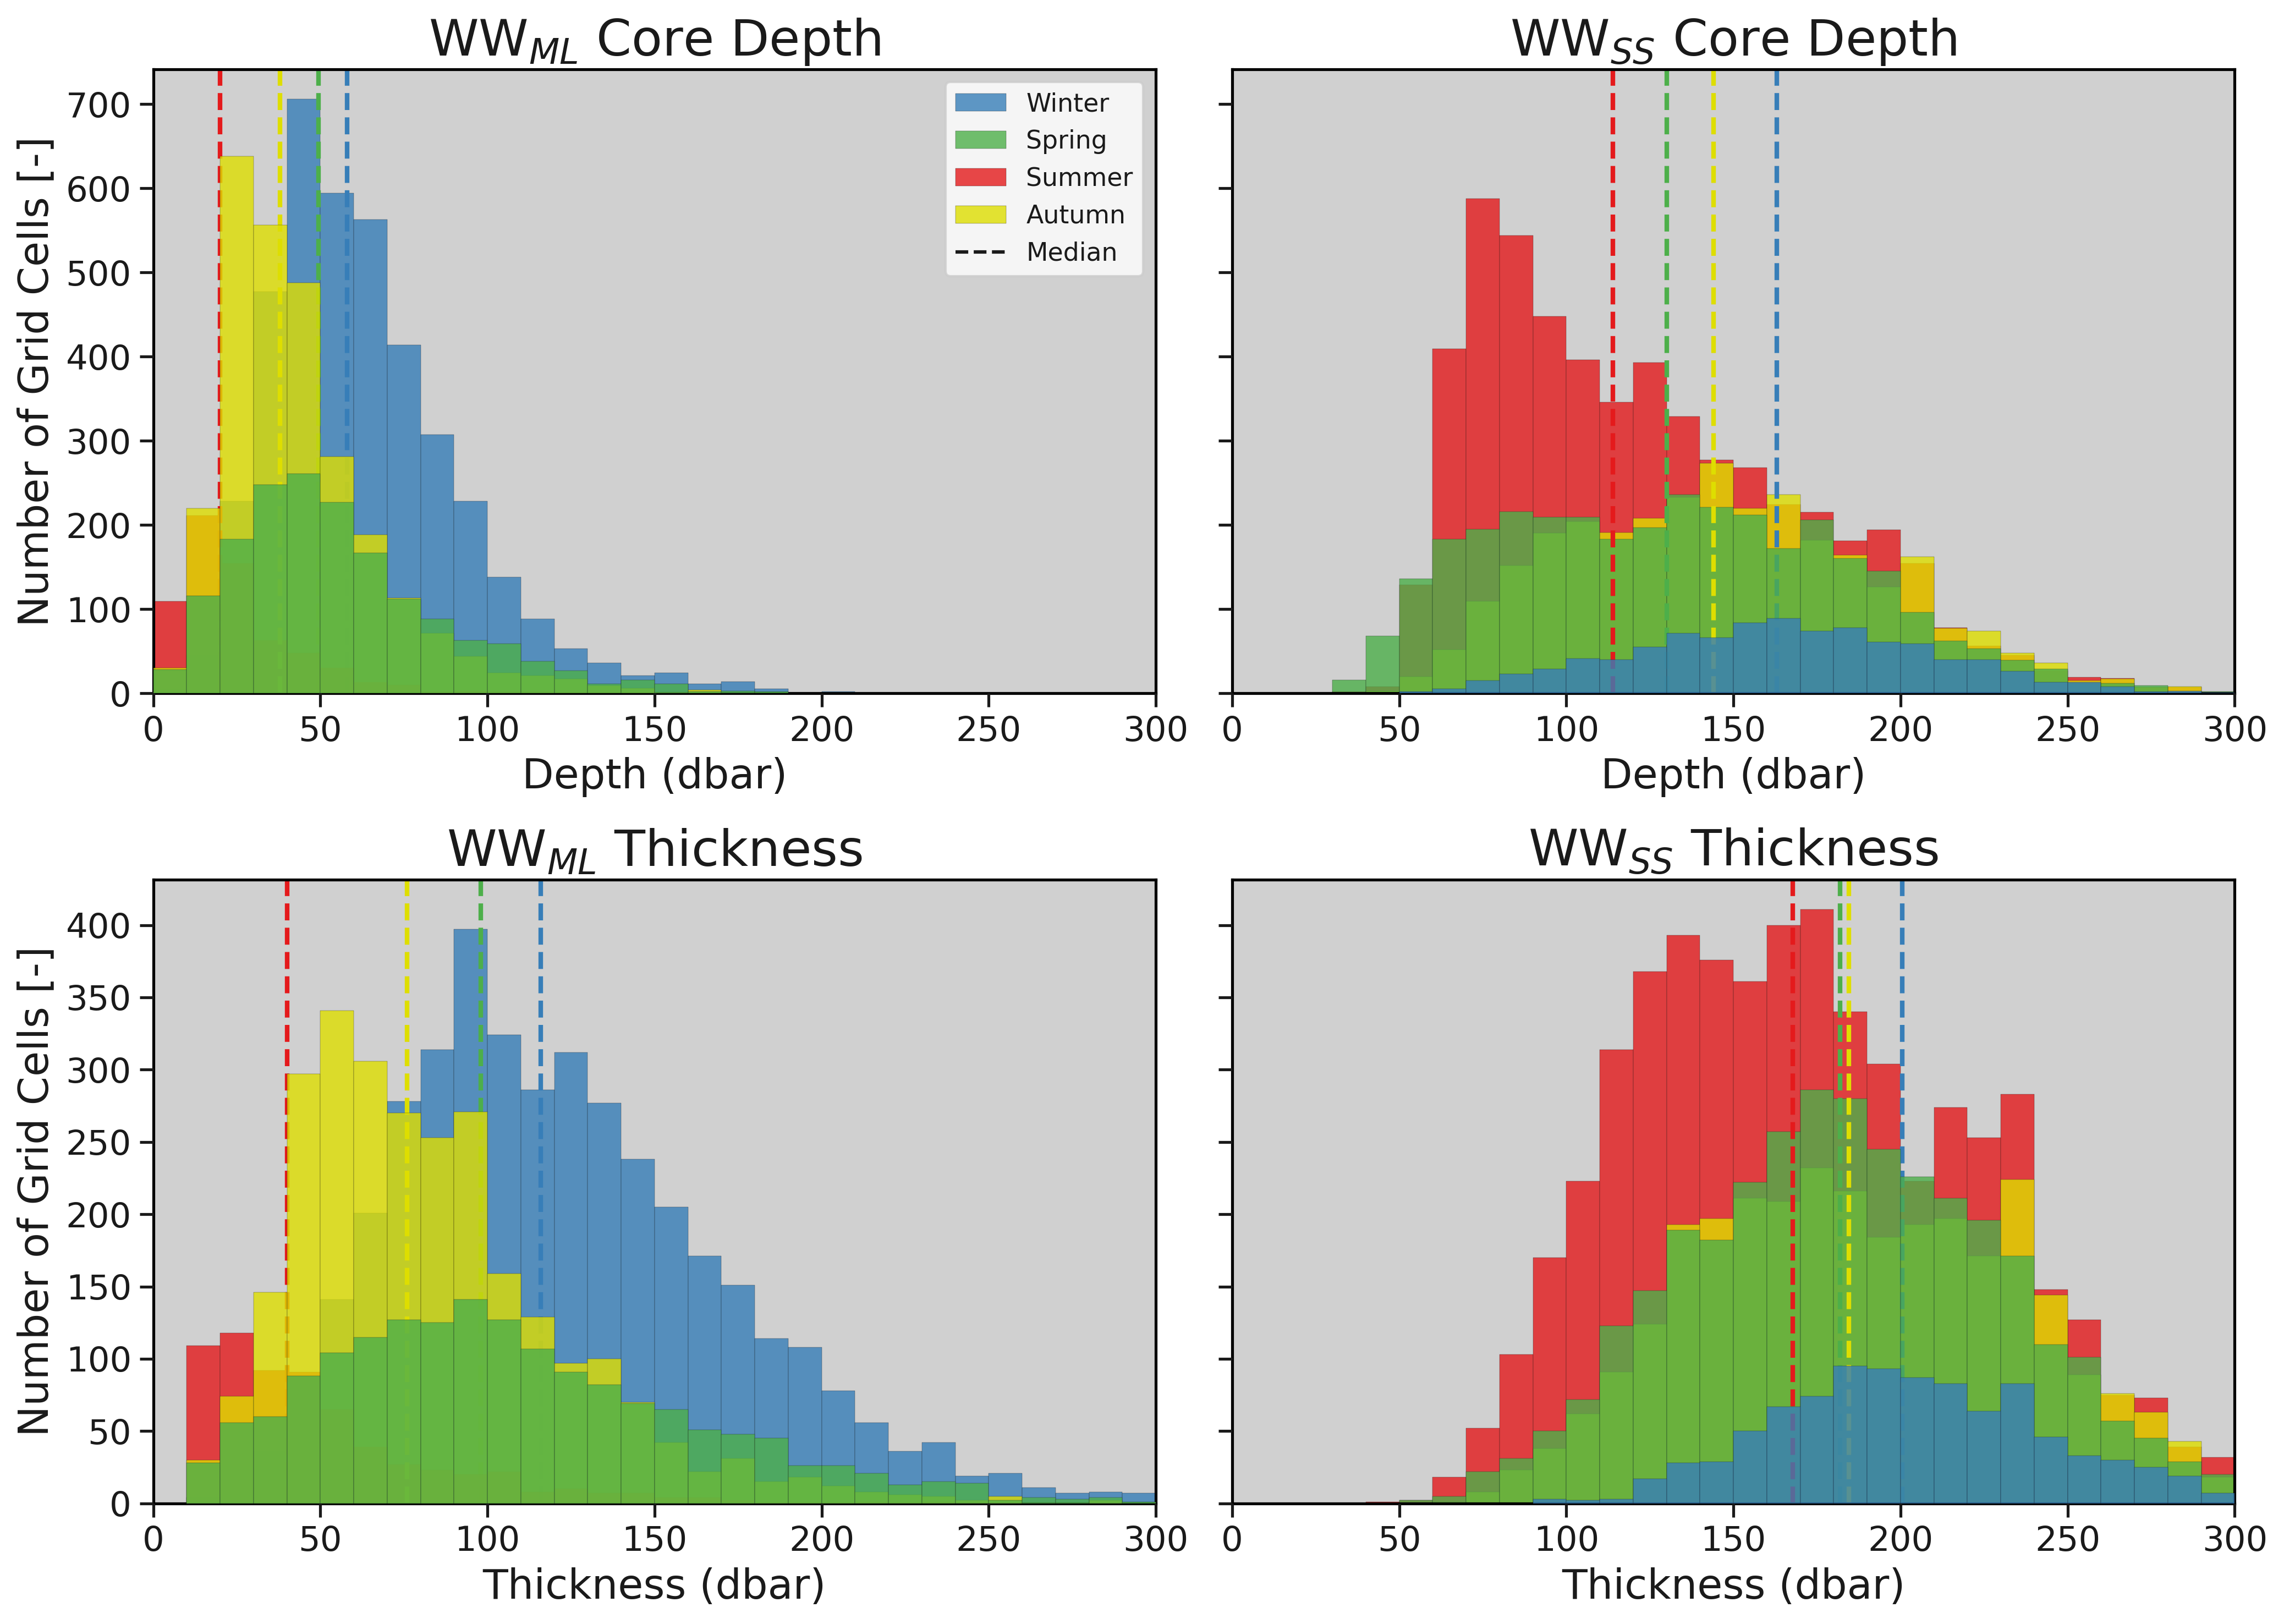

In [4]:
fig,ax = plt.subplots(2,2,figsize=(14,10),sharex='row',sharey='row',dpi=300)
ax = ax.flatten()

plot_variable_histogram(ax=ax[:2],ds=ds_ww,var='ww_cp',var_name='Core Depth',z_ss=[4,2,0,1])
plot_variable_histogram(ax=ax[-2:],ds=ds_ww,var='thcc',var_name='Thickness',z_ss=[4,2,0,1],add_legend=0)

for a in ax[:2]:
    a.set_xlabel('Depth (dbar)')
for a in ax[-2:]:
    a.set_xlabel('Thickness (dbar)')
fig.tight_layout()

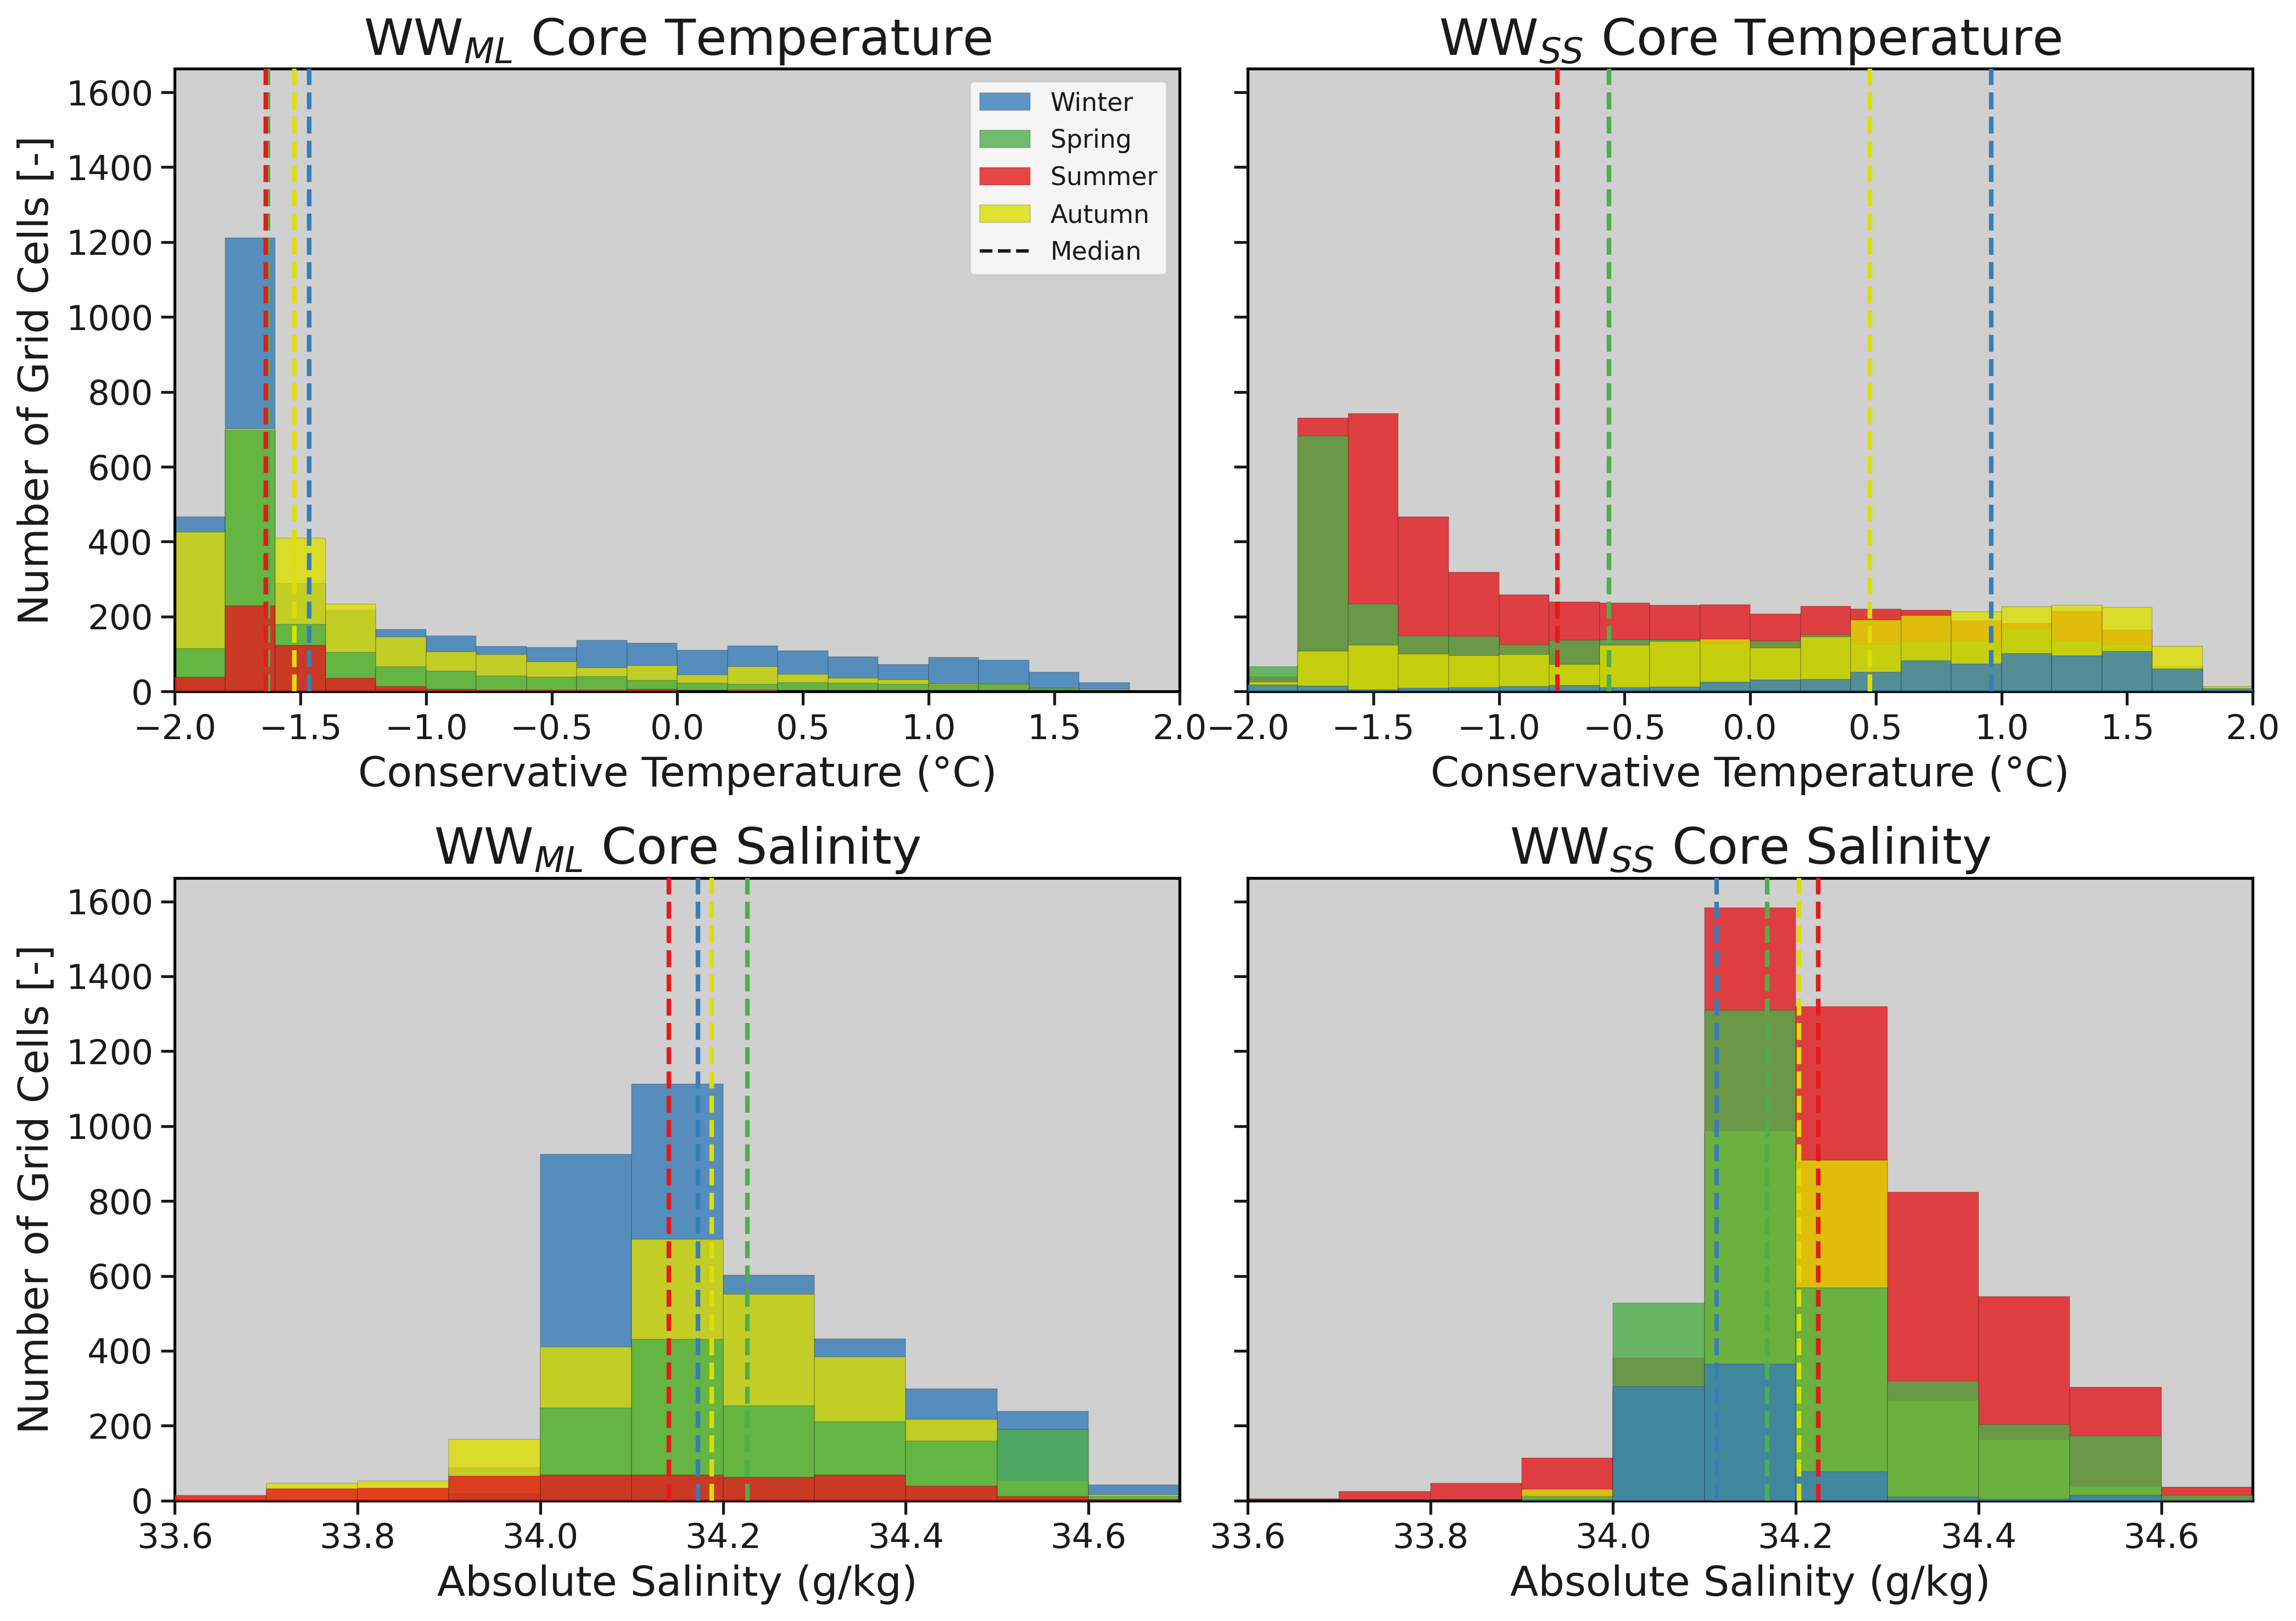

In [8]:
fig,ax = plt.subplots(2,2,figsize=(14,10),sharex='row',sharey=1,dpi=300)
ax = ax.flatten()

plot_variable_histogram(ax=ax[:2],ds=ds_ww,var='ww_ct',var_name='Core Temperature',
                        bins=np.arange(-2,2.1,.2), z_ml=[0,2,3,1], z_ss=[3,1,0,2])
plot_variable_histogram(ax=ax[-2:],ds=ds_ww,var='ww_sa',var_name='Core Salinity', add_legend=0,
                        bins=np.arange(33.6,34.8,.1),z_ml=[0,2,3,1], z_ss=[4,3,1,2],)

for a in ax[:2]:
    a.set_xlabel('Conservative Temperature (°C)')
for a in ax[-2:]:
    a.set_xlabel('Absolute Salinity (g/kg)')
fig.tight_layout()

(array([ 123.,  146.,  167.,  191.,  219.,  214.,  264.,  245.,  332.,
         351.,  458.,  564.,  700.,  854., 1007., 1040., 1116., 1212.,
        1230., 1227., 1322., 1231., 1095.,  981.,  887.,  756.,  604.,
         468.,  411.,  322.,  252.,  214.,  177.,  167.,  134.,   79.,
          96.,  106.,   57.,   54.,   55.,   35.,   27.,   28.,   23.,
          10.,    8.,   17.,   13.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196.]),
 <BarContainer object of 49 artists>)

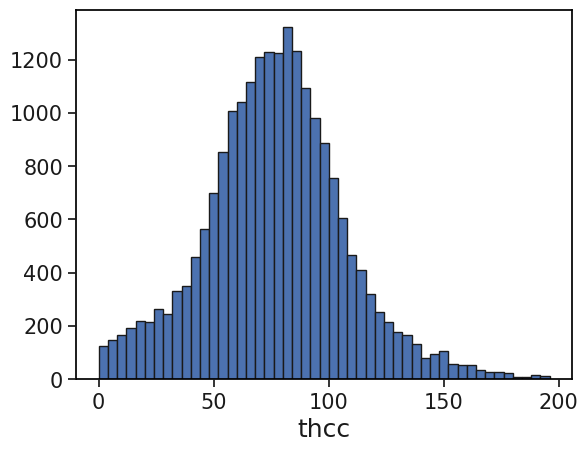

In [16]:
ds_ww.thcc.plot.hist(bins=np.arange(0,200,4))

KeyError: 'ww_cp'

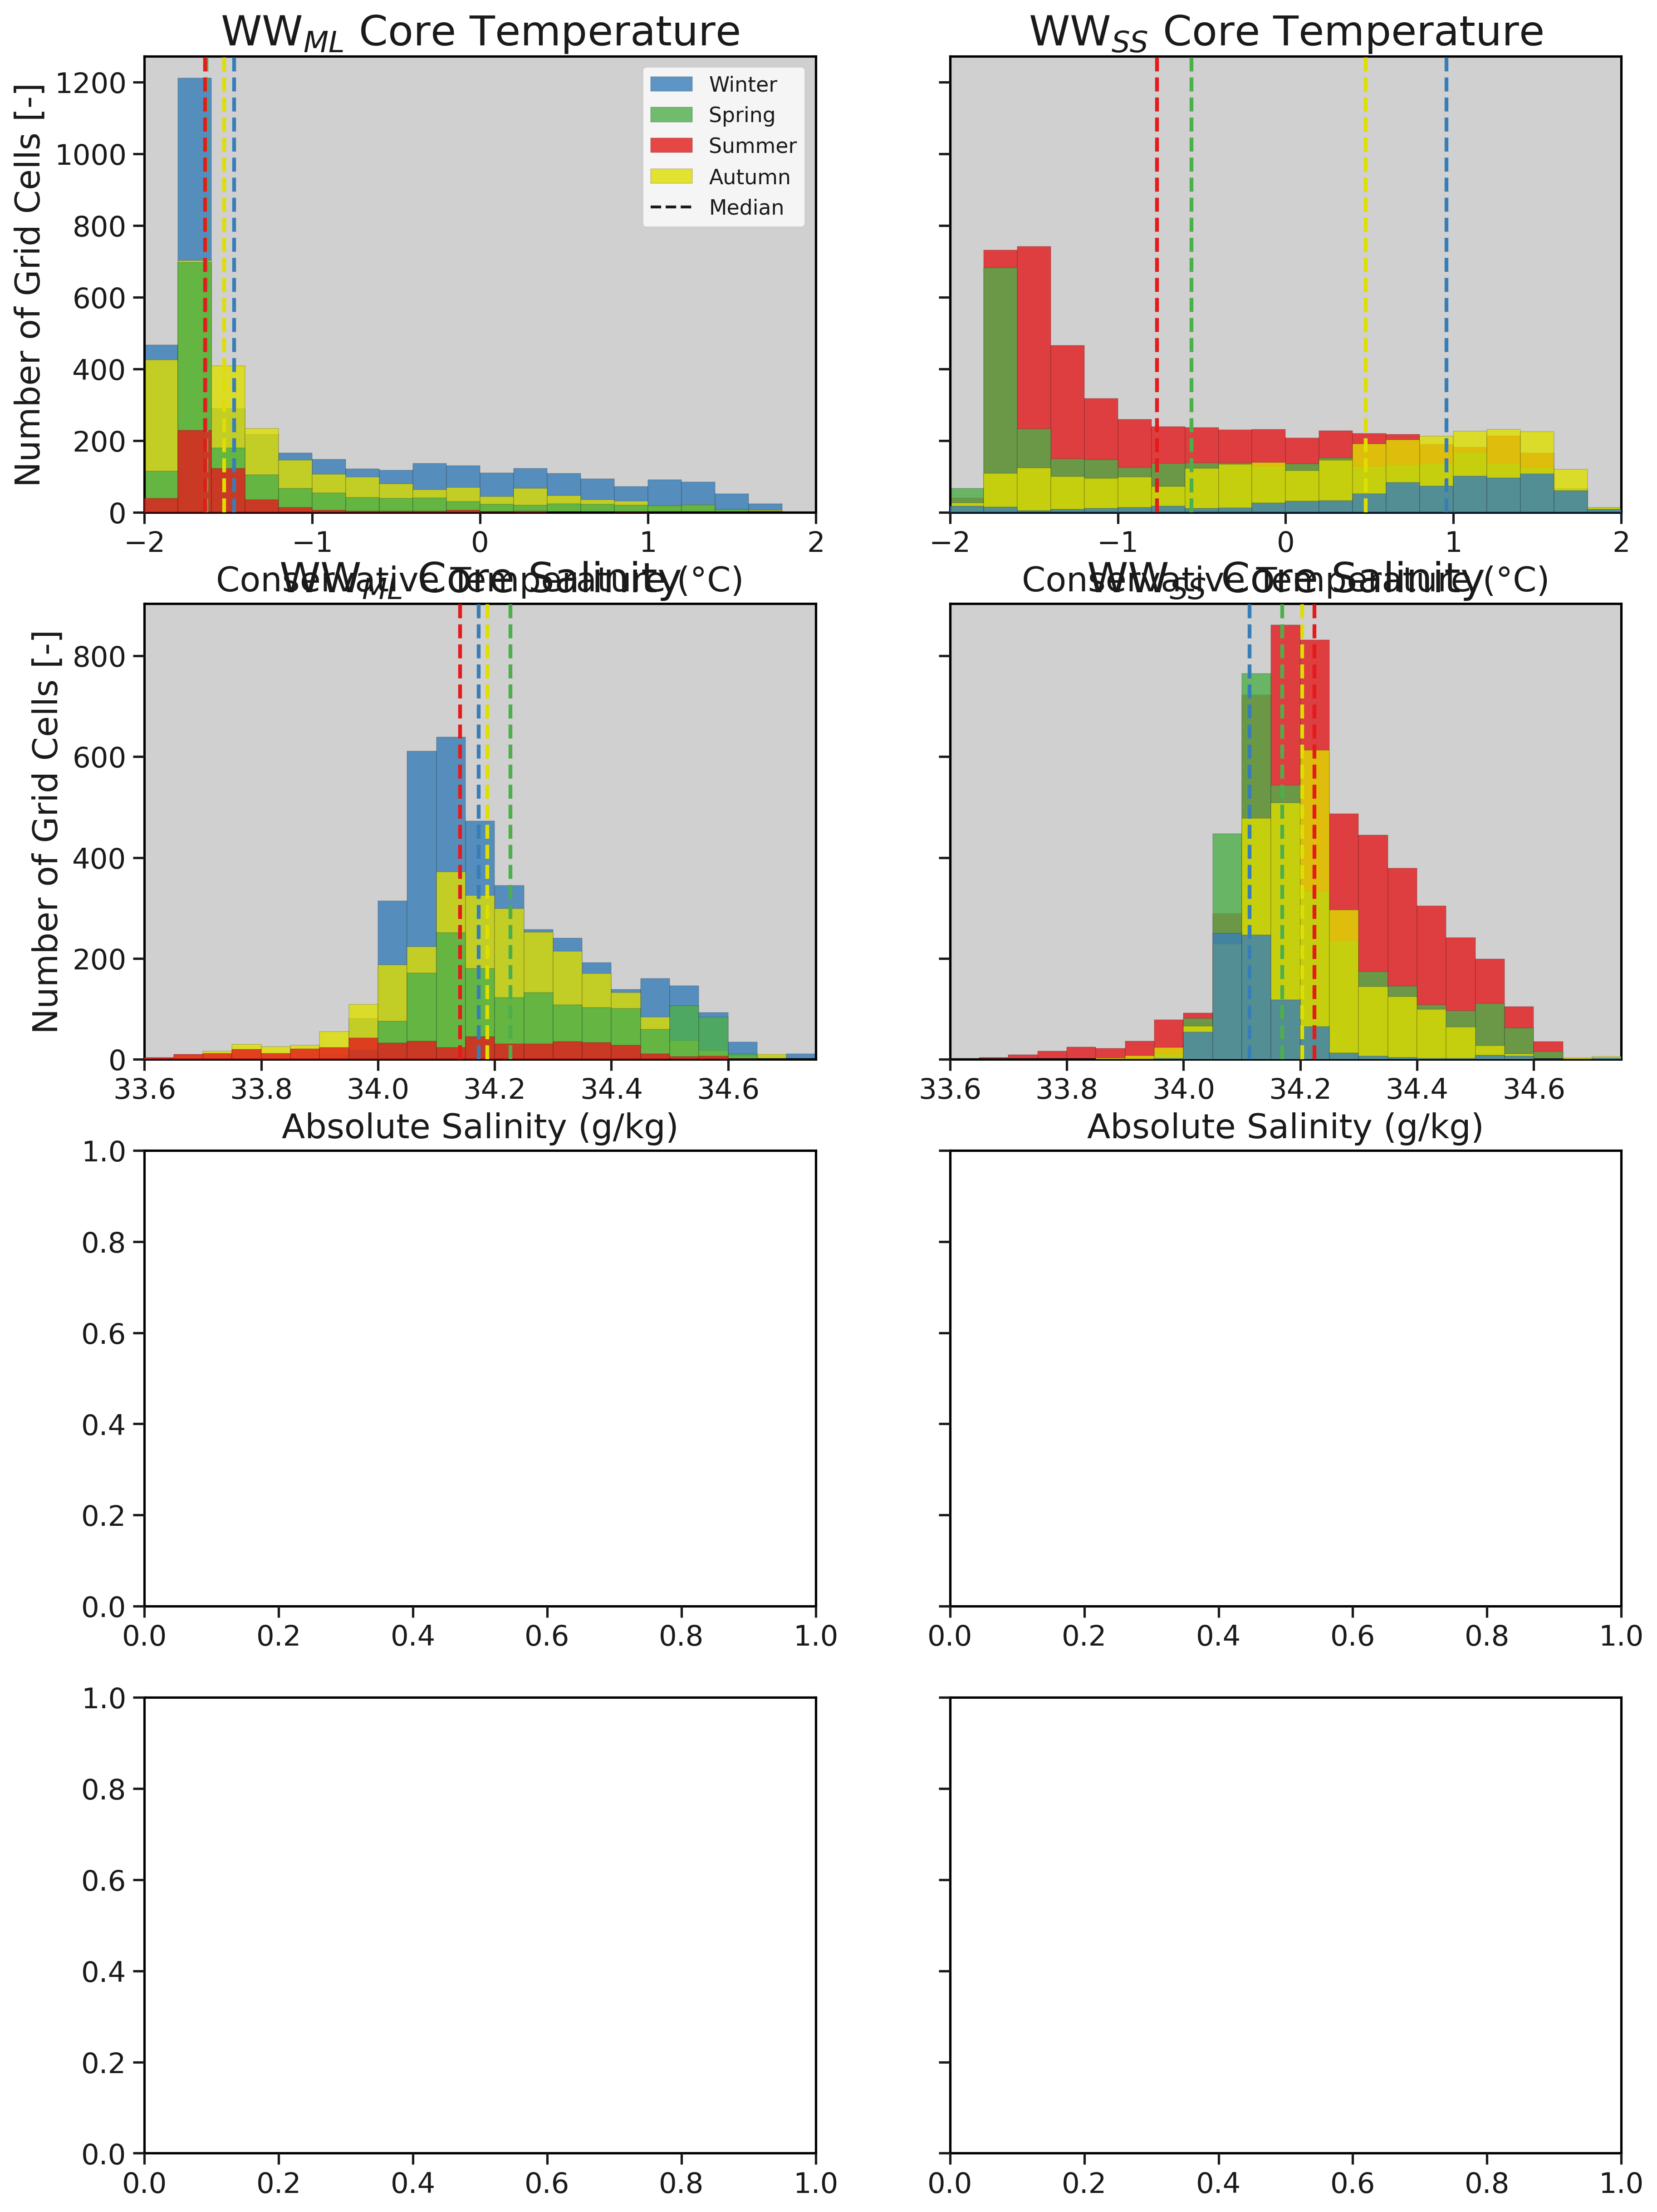

In [20]:
fig,ax = plt.subplots(4,2,figsize=(14,20),sharex='row',sharey='row',dpi=300)
ax = ax.flatten()

# plot core T & S
plot_variable_histogram(ax=ax[:2],ds=ds_ww,var='ww_ct',var_name='Core Temperature', add_legend=1,
                        bins=np.arange(-2,2.1,.2), z_ml=[0,2,4,1], z_ss=[3,1,0,2])
plot_variable_histogram(ax=ax[2:4],ds=ds_ww,var='ww_sa',var_name='Core Salinity', add_legend=0,
                        bins=np.arange(33.6,34.8,.05),z_ml=[0,2,3,1], z_ss=[4,2,1,3],)

for a in ax[:2]:
    a.set_xlabel('Conservative Temperature (°C)')
for a in ax[2:4]:
    a.set_xlabel('Absolute Salinity (g/kg)')

# plot depth and thickness
plot_variable_histogram(ax=ax[4:6],ds=ds_ww,var='ww_cp',var_name='Core Depth',z_ml=[0,2,3,1],z_ss=[4,1,0,2],add_legend=0)
plot_variable_histogram(ax=ax[-2:],ds=ds_ww,var='thcc',var_name='Thickness',z_ml=[0,2,3,1],
                        z_ss=[4,1,0,2],add_legend=0,)

for a in ax[4:6]:
    a.set_xlabel('Depth (dbar)')
for a in ax[-2:]:
    a.set_xlabel('Thickness (dbar)')

fig.tight_layout()

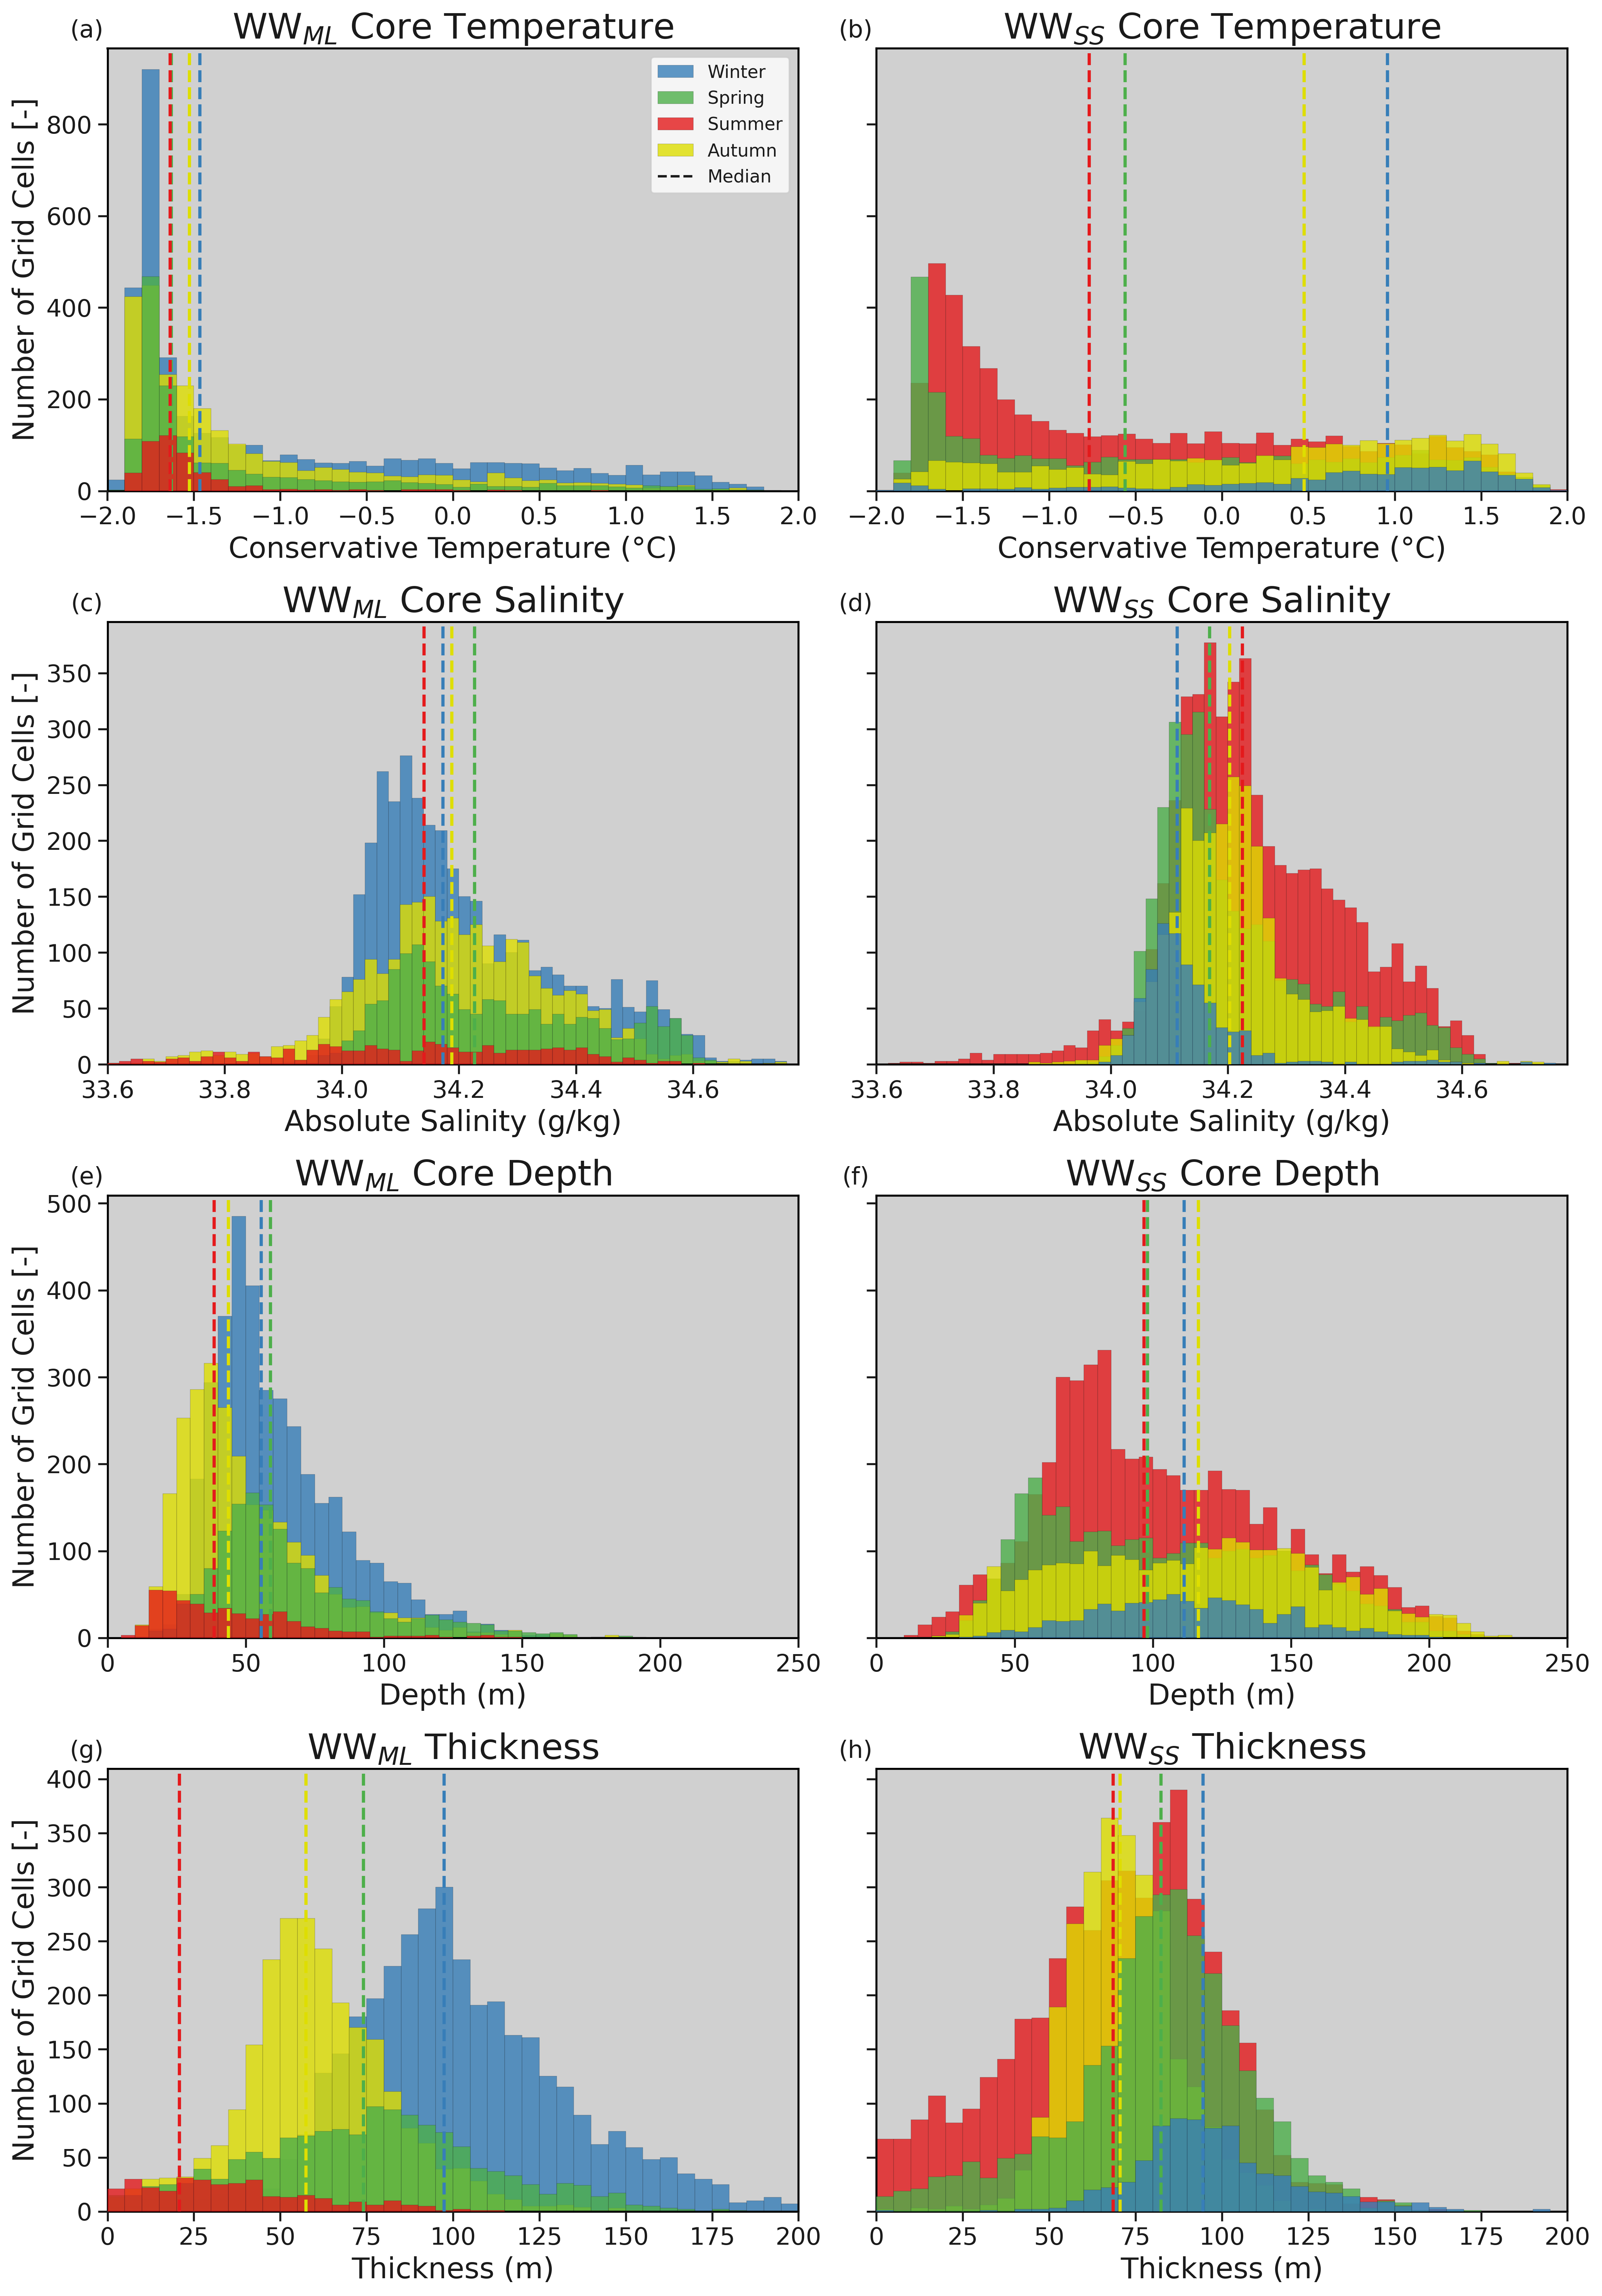

In [34]:
fig,ax = plt.subplots(4,2,figsize=(14,20),sharex='row',sharey='row',dpi=300)
ax = ax.flatten()

# plot core T & S
plot_variable_histogram(ax=ax[:2],ds=ds_ww,var='ww_ct',var_name='Core Temperature', add_legend=1,
                        bins=np.arange(-2,2.1,.1), z_ml=[0,2,4,1], z_ss=[3,1,0,2])
plot_variable_histogram(ax=ax[2:4],ds=ds_ww,var='ww_sa',var_name='Core Salinity', add_legend=0,
                        bins=np.arange(33.6,34.8,.02),z_ml=[0,2,3,1], z_ss=[4,2,1,3],)

for a in ax[:2]:
    a.set_xlabel('Conservative Temperature (°C)')
for a in ax[2:4]:
    a.set_xlabel('Absolute Salinity (g/kg)')

# plot depth and thickness
plot_variable_histogram(ax=ax[4:6],ds=ds_ww,var='ww_cd',var_name='Core Depth',z_ml=[0,2,3,1],
                        z_ss=[4,1,0,2],add_legend=0,bins=np.arange(0,251,5))
plot_variable_histogram(ax=ax[-2:],ds=ds_ww,var='thcc',var_name='Thickness',z_ml=[0,2,3,1],
                        z_ss=[4,3,1,2],add_legend=0,bins=np.arange(0,201,5))

for a in ax[4:6]:
    a.set_xlabel('Depth (m)')
for a in ax[-2:]:
    a.set_xlabel('Thickness (m)')

labels = [chr(i) for i in range(ord('a'), ord('z')+1)]
for i,a in enumerate(ax):
    a.annotate(text='('+labels[i]+')', xy=(-0.03, 1.025), xycoords='axes fraction', fontsize=15, ha='center')
    
fig.tight_layout()

# add a column with both

In [10]:
def plot_variable_histogram_3(ax, ds, var, var_name, bins=np.arange(0, 301, 10), add_legend=1,
                              z_ml=None, z_ss=None, z_both=None, stat='mean',):
    """
    Plots histograms for two categories (ML and SS) of a given variable across four seasons,
    ordering them by their total area so that the largest histogram is at the back and the smallest is at the front.

    Parameters:
    - ax: A list of Matplotlib axes objects where the first element is for ML category and the second for SS category.
    - ds: A xarray Dataset containing the variable of interest and the ww_type attribute indicating the category (ML or SS).
    - var: The name of the variable to plot histograms for.
    - bins: An optional parameter specifying the bin edges for the histogram. Default is evenly spaced values from 0 to 300.
    - add_legend: A boolean flag indicating whether to add a legend to the first subplot. Default is True.
    - z_ml: Optional list of z-order values for the ML category histograms. If None, calculated based on histogram areas.
    - z_ss: Optional list of z-order values for the SS category histograms. If None, calculated based on histogram areas.

    Description:
    This function dynamically calculates the area under each histogram and sorts them before plotting,
    ensuring that the histogram with the largest area is plotted last, and the one with the smallest area is plotted first.
    This approach enhances the visibility of the smaller histograms behind the larger ones, providing a clearer comparison
    between the ML and SS categories across four seasons (Winter, Spring, Summer, Autumn). The z-ordering of the histograms
    can be manually specified through the z_ml and z_ss parameters, or automatically calculated based on the histogram areas
    if these parameters are set to None.

    Implementation Details:
    - Season names and color codes are predefined to maintain consistency across plots.
    - Data filtering is performed using the .where() method on the dataset, selecting rows where the ww_type attribute matches either ML (2) or SS (1).
    - The area under each histogram is calculated using np.sum(), and the histograms are sorted based on these areas.
    - Z-ordering is applied to differentiate between seasons and categories in the overlaying histograms, ensuring visual clarity.
    - Histogram plotting parameters are standardized to ensure uniformity across all plots generated by this function.
    - Titles for the subplots are constructed dynamically using the variable name, enhancing the interpretability of the plots.
    - Legends are conditionally added to the first subplot based on the add_legend flag, providing additional context for the data visualization.
    - X-axis limits are set globally for both subplots to ensure consistency in the scale of the histograms.
    """
    
    # Define season names and color codes
    szn = ['Winter', 'Spring', 'Summer', 'Autumn']
    colors = ['#377eb8', '#4daf4a', '#e41a1c', '#dede00',]
    
    # Filter the dataset for ML and SS categories
    thcc_ss = ds[var].where(ds_ww.ww_type==2)
    thcc_ml = ds[var].where(ds_ww.ww_type==1)
    both    = ds[var]
    
    # Calculate the area under each histogram and sort them if z_ml and z_ss are None
    if z_ml is None:
        areas_ml = [np.sum(thcc_ml[i]) for i in range(4)]
        sorted_indices_ml = np.argsort(areas_ml)[::-1]  # Sort in descending order
        z_ml = sorted_indices_ml + 1  # Adjusted to start from 1 for z-ordering
    if z_ss is None:
        areas_ss = [np.sum(thcc_ss[i]) for i in range(4)]
        sorted_indices_ss = np.argsort(areas_ss)[::-1]  # Sort in descending order
        z_ss = sorted_indices_ss + 1  # Adjusted to start from 1 for z-ordering
    if z_both is None:
        areas_b = [np.sum(both[i]) for i in range(4)]
        sorted_indices_b = np.argsort(areas_b)[::-1]  # Sort in descending order
        z_both = sorted_indices_b + 1  # Adjusted to start from 1 for z-ordering
    
    # Histogram plotting parameters
    hist_kwargs = dict(bins=bins, alpha=0.6, edgecolor=None, linewidth=0.1)
    for i in range(4):
        # Plot histograms for ML and SS categories separately, ordered by their areas
        thcc_ml[i].plot.hist(color=colors[i], label=szn[i], ax=ax[0], **hist_kwargs, zorder=z_ml[i])
        add_stat(thcc_ml,ax[0],i,colors,bins,stat=stat)
        
        thcc_ss[i].plot.hist(color=colors[i], label=szn[i], ax=ax[1], **hist_kwargs, zorder=z_ss[i])
        add_stat(thcc_ss,ax[1],i,colors,bins,stat=stat)

        both[i].plot.hist(color=colors[i], label=szn[i], ax=ax[2], **hist_kwargs, zorder=z_both[i])
        add_stat(both,ax[2],i,colors,bins,stat=stat)
    
    # Set titles for the subplots
    ax[0].set_title(r'WW$_{ML}$ '+var_name, fontsize=20)
    ax[1].set_title(r'WW$_{SS}$ '+var_name, fontsize=20)
    ax[2].set_title(var_name+' of Both\nWW Classifications',fontsize=20)

    
    # Add legend to the first subplot
    if add_legend:
        # add a grey dashed line to the legend
        ax[0].plot([], [], 'k--', label=stat.capitalize())
        ax[0].legend()
    
    # Set x-axis limits for both subplots
    ax[0].set_xlim(bins.min(), bins.max())
    ax[0].set_ylabel('Number of Grid Cells [-]')

    for a in ax:
        a.set_facecolor('#d0d0d0')

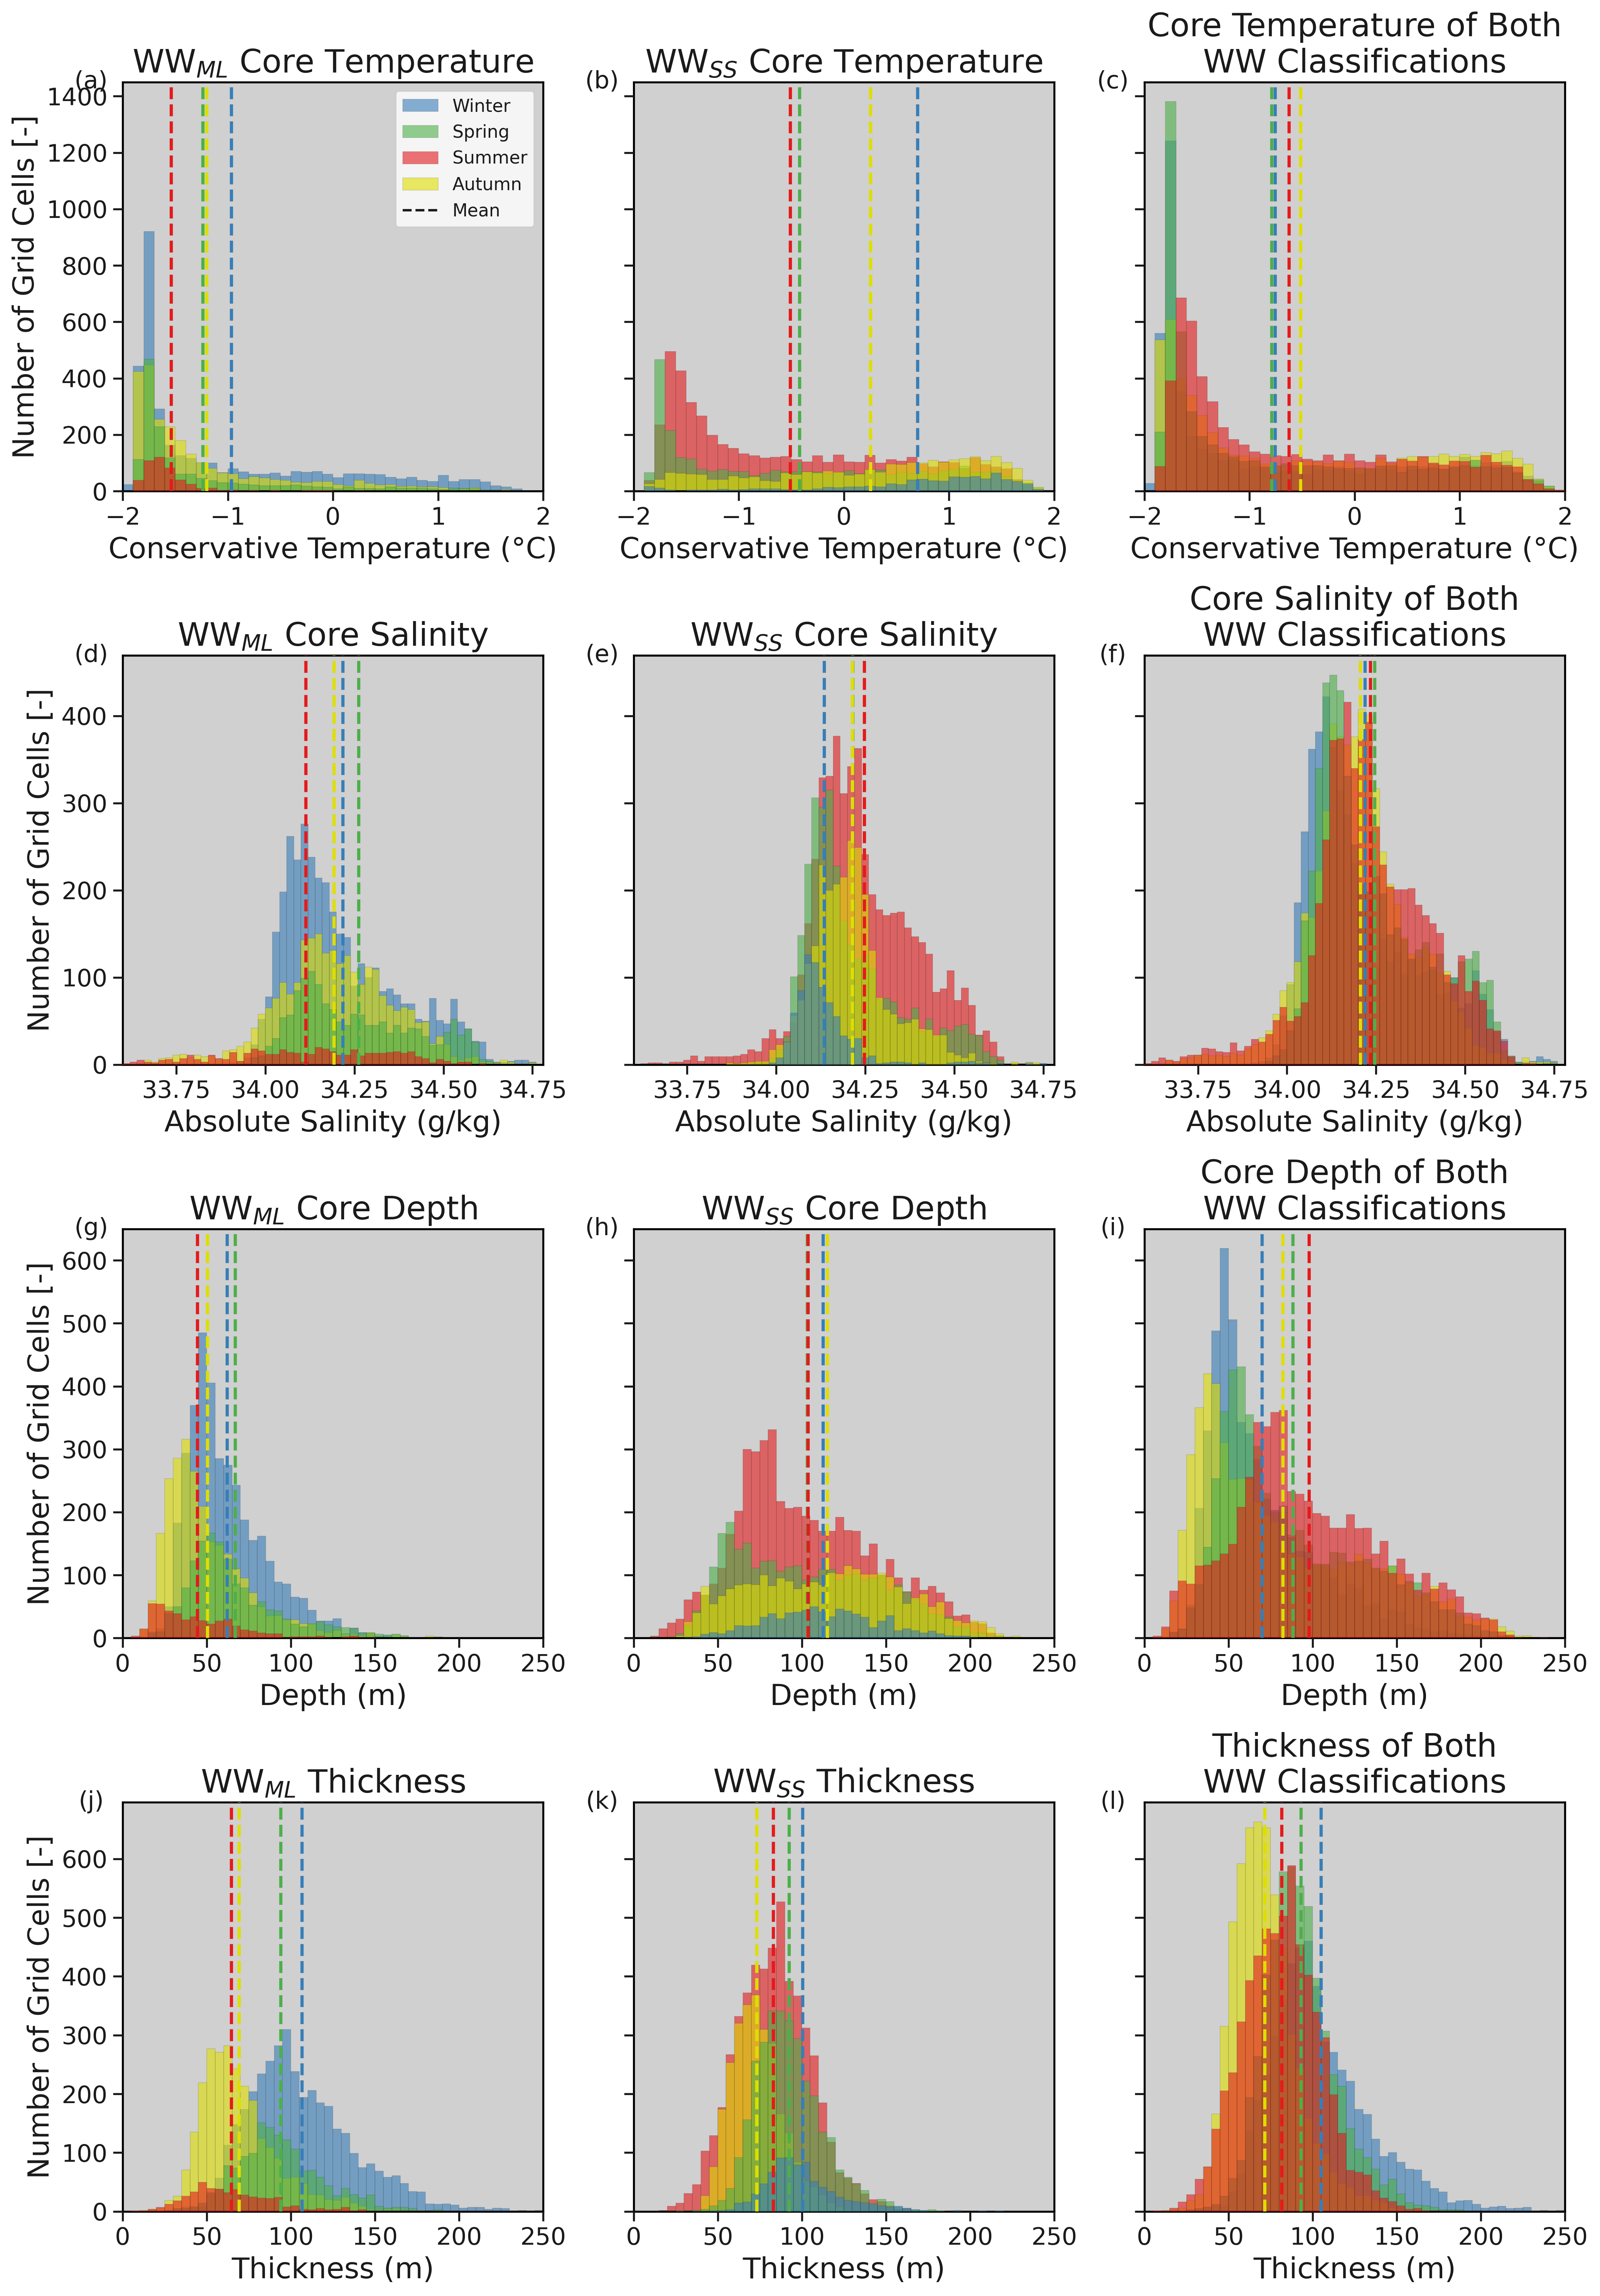

In [11]:
fig,ax = plt.subplots(4,3,figsize=(14,20),sharex='row',sharey='row',dpi=300)
ax = ax.flatten()

# plot core T & S
plot_variable_histogram_3(ax=ax[:3],ds=ds_ww,var='ww_ct',var_name='Core Temperature', add_legend=1,
                        bins=np.arange(-2,2.1,.1), z_ml=[0,2,4,1], z_ss=[3,1,0,2], z_both=[0,2,4,1])
plot_variable_histogram_3(ax=ax[3:6],ds=ds_ww,var='ww_sa',var_name='Core Salinity', add_legend=0,
                        bins=np.arange(33.6,34.8,.02),z_ml=[0,2,3,1], z_ss=[4,2,1,3],z_both=[0,2,3,1])

for a in ax[:3]:
    a.set_xlabel('Conservative Temperature (°C)')
for a in ax[3:6]:
    a.set_xlabel('Absolute Salinity (g/kg)')

# plot depth and thickness
plot_variable_histogram_3(ax=ax[6:9],ds=ds_ww,var='ww_cd',var_name='Core Depth',z_both=[0,2,3,1],
                          z_ml=[0,2,3,1],z_ss=[4,1,0,2],add_legend=0,bins=np.arange(0,251,5))
plot_variable_histogram_3(ax=ax[-3:],ds=ds_ww,var='thcc',var_name='Thickness',z_both=[0,2,3,1],
                          z_ml=[0,2,3,1],z_ss=[4,3,1,2],add_legend=0,bins=np.arange(0,251,5))

for a in ax[6:9]:
    a.set_xlabel('Depth (m)')
for a in ax[-3:]:
    a.set_xlabel('Thickness (m)')

labels = [chr(i) for i in range(ord('a'), ord('l')+1)]
for i,a in enumerate(ax):
    a.annotate(text='('+labels[i]+')', xy=(-0.075, .985), xycoords='axes fraction', fontsize=15, ha='center')

fig.tight_layout()

# figure out adding gridlines to circumpolar plots

In [26]:
import importlib
#importlib.reload(sys.modules['load_data'])

path = '/home/theospira/notebooks/projects/WW_climatology'

import sys
sys.path.append(path+'/functions')
from plot_formatting import *
from inspection_funcs import boxplot
from smoothing_and_interp import *

In [74]:
importlib.reload(sys.modules['plot_formatting'])
from plot_formatting import *

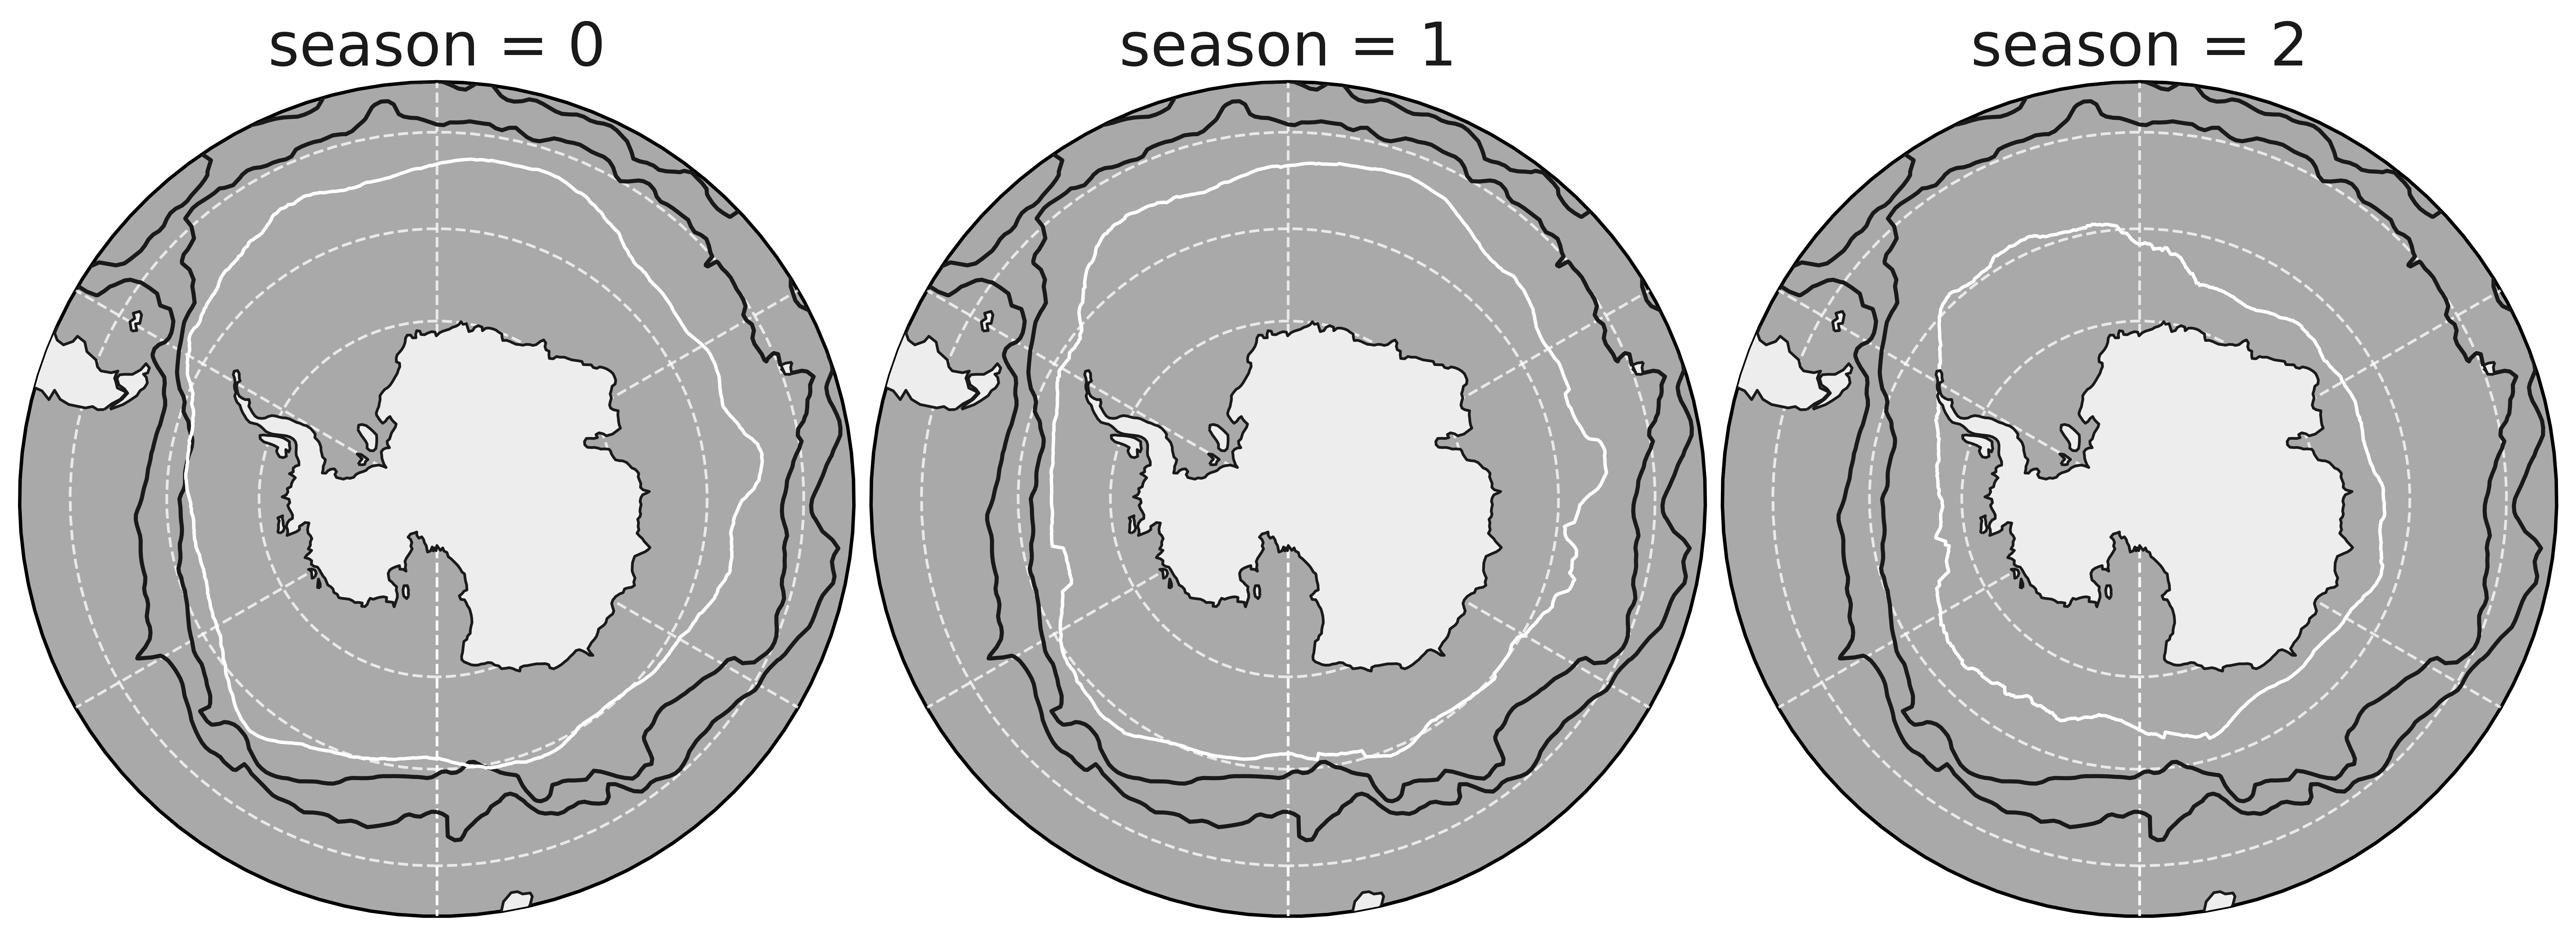

In [75]:
fig,ax = plt.subplots(1,3,figsize=[13,17.5],constrained_layout=True,
                      subplot_kw={'projection': ccrs.SouthPolarStereo(),}, dpi=600)
ax=ax.flatten()

circular_plot_fomatting(fig,ax,ds=ds,si=si,bathym=False,annotation=False,)

## for another time...

Identifying proifles that contain spurious patches of nans in the middle. probs should be removed...

In [65]:
num_invs[num_invs.sum('pres')<2].n_prof

<xarray.DataArray 'n_prof' (n_prof: 2602)>
array([   615,    677,    683, ..., 617256, 617257, 618912])
Coordinates:
  * n_prof   (n_prof) int64 615 677 683 743 910 ... 617146 617256 617257 618912
    lon      (n_prof) float64 -171.4 -179.8 -179.8 ... -99.47 80.52 -175.9
    lat      (n_prof) float64 -72.03 -69.11 -69.09 ... -51.81 -51.81 -71.87
    time     (n_prof) datetime64[ns] 2004-03-18T19:30:00 ... 2021-12-03T14:11:26

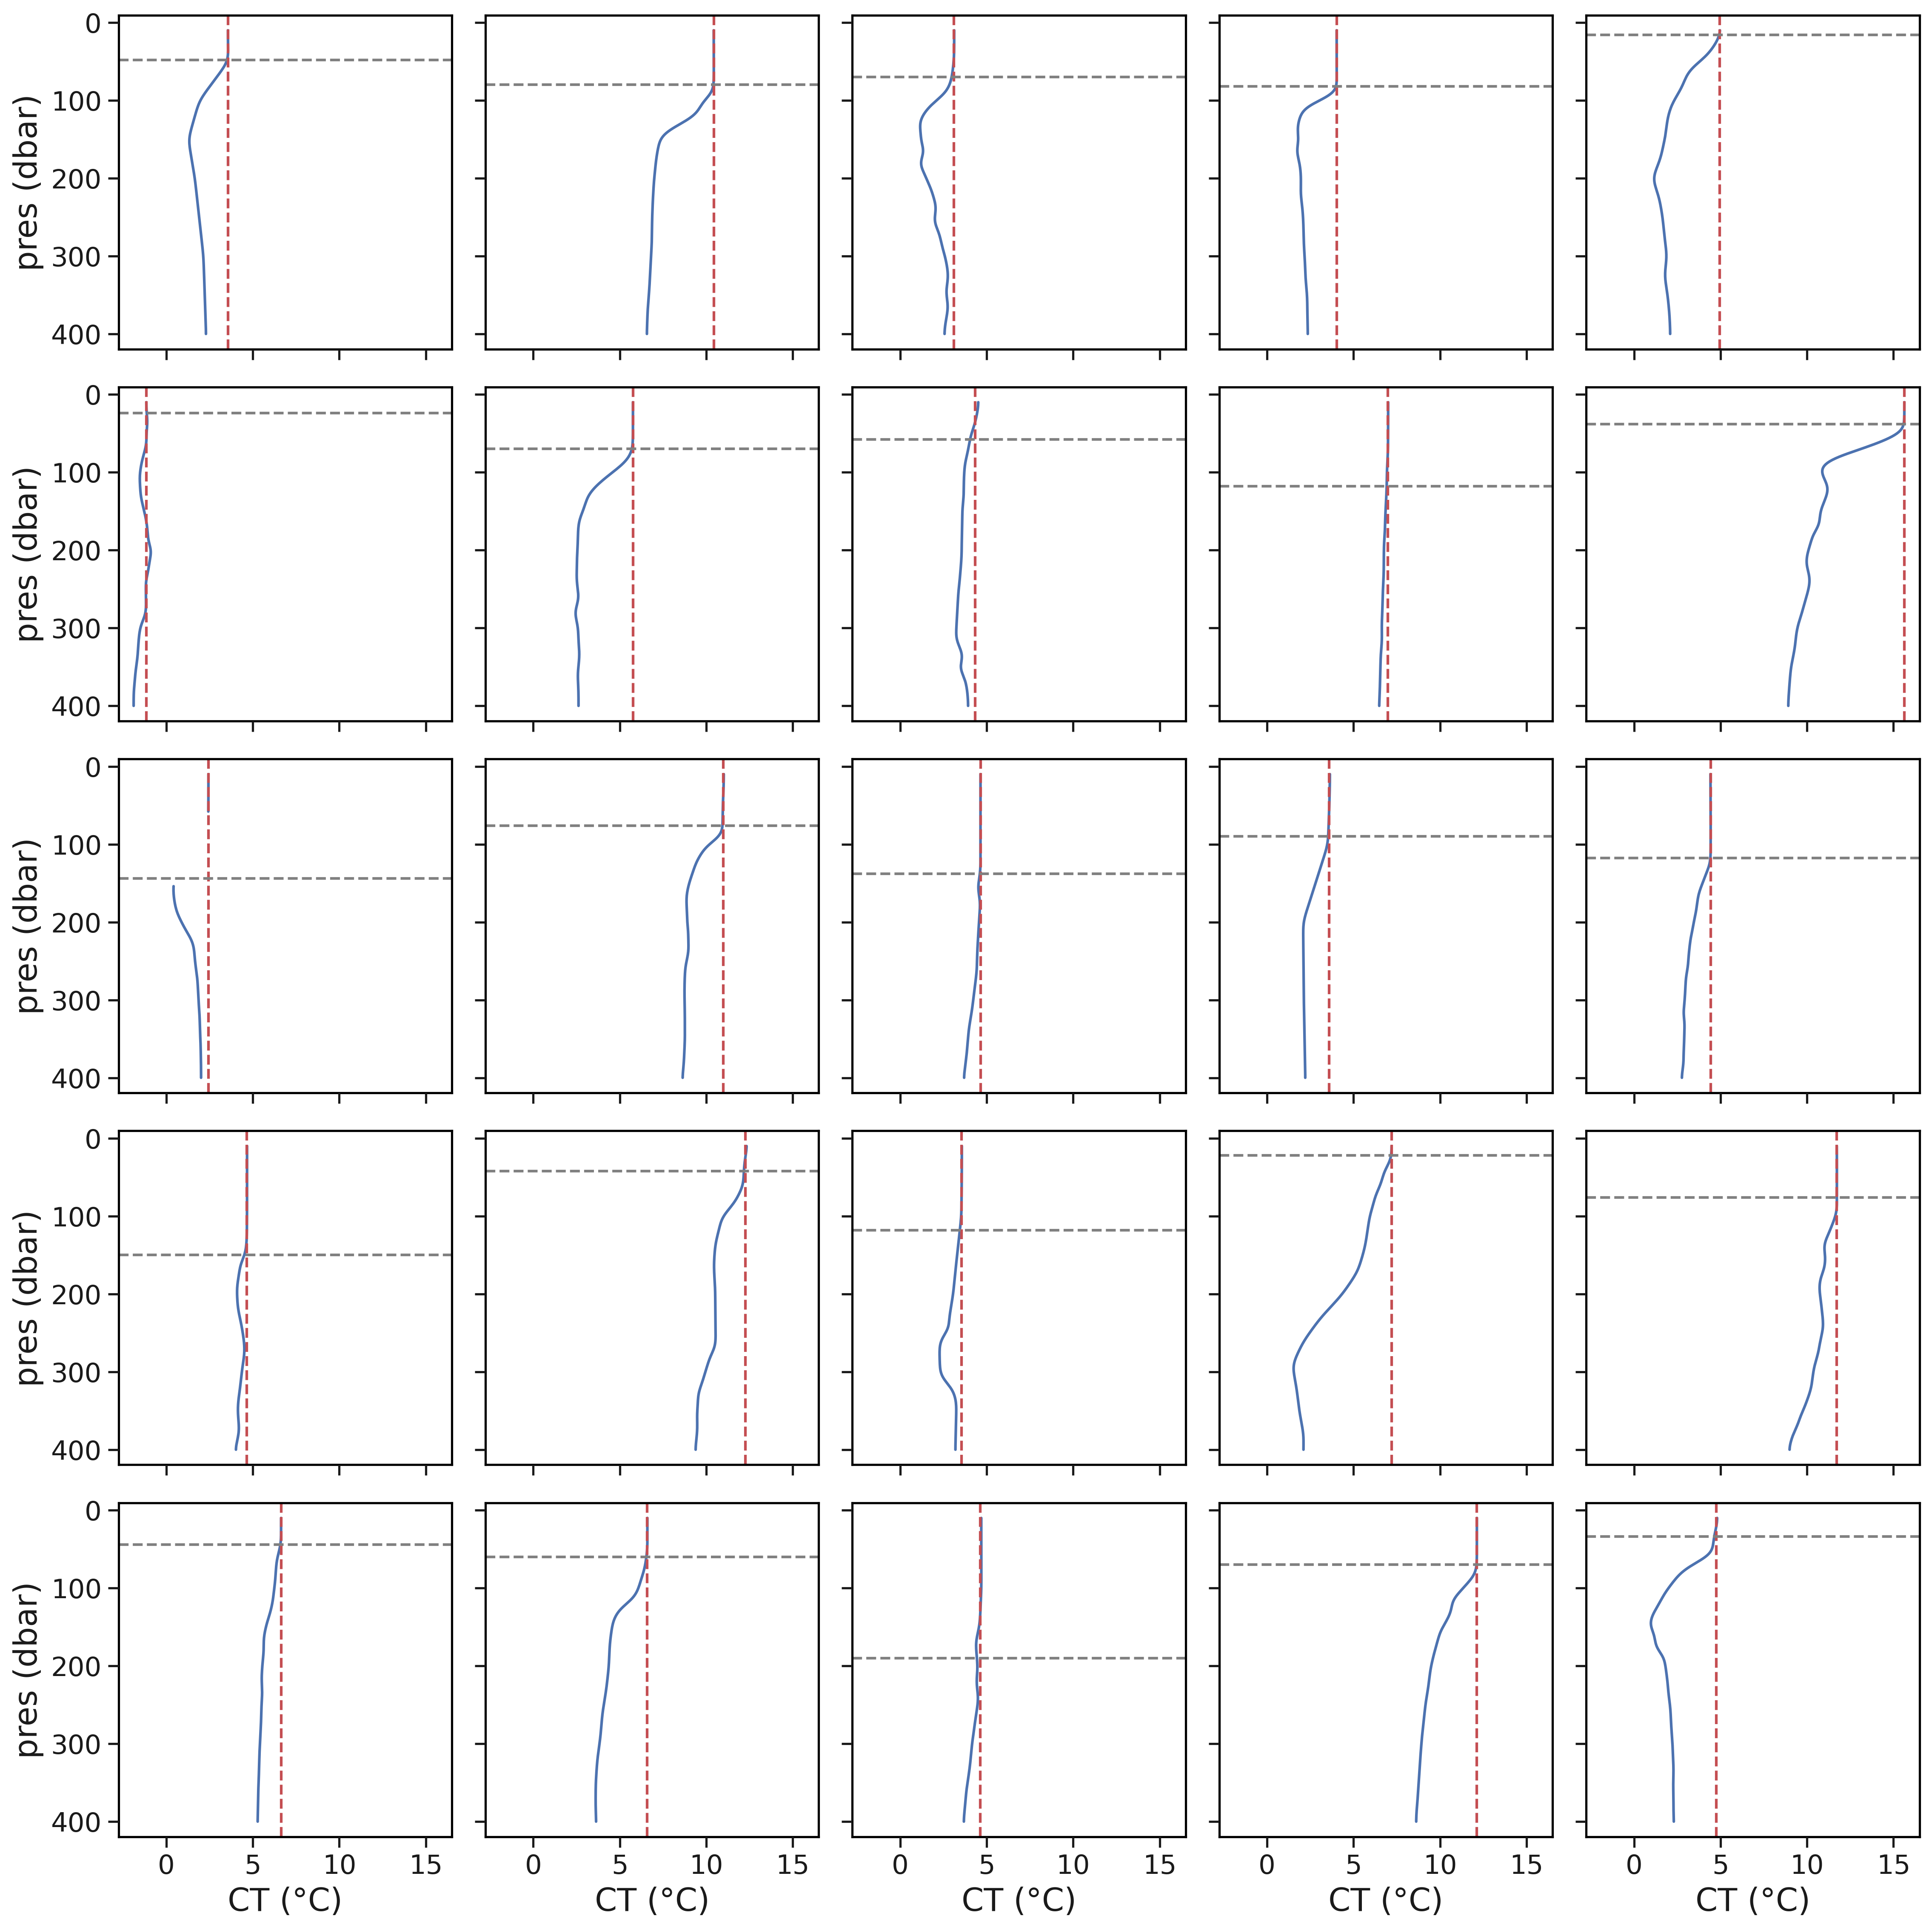

In [74]:
# randomly selected deep mixing profiles

r = 5
fig, ax = plt.subplots(r, r, figsize=(15, 15), sharey=True, sharex=True, dpi=300)
ax = ax.flatten()

# randomly select some profiles
x = np.asarray(np.random.choice(num_invs[num_invs.sum('pres')>100].n_prof, r**2, replace=0))

# Loop over each subplot
for i, l, a in zip(range(len(ax)), x, ax):
    # Plot the original data
    ds.sel(n_prof=l).ctemp.plot(y='pres', ax=a)

    a.invert_yaxis()
    a.set_title('')
    a.set_xlabel('')
    a.set_ylabel('')

    a.axvline(ml_t.sel(n_prof=l),ls='--',c='r')
    a.axhline(ds.mlp.sel(n_prof=l),ls='--',c='grey')

# Set global limits for the plots
#plt.xlim(-2, 3)
plt.tight_layout()
#plt.show()

for a in ax[-r:]:
    a.set_xlabel('CT (°C)')

for a in ax[::5]:
    a.set_ylabel('pres (dbar)')

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  957.,
        1725., 1760., 1680., 1777., 1718., 1694., 1732., 1796., 3536.,
        2016., 1823., 1865., 2451., 1497., 1782., 1495., 1428., 1477.,
        1363., 1429., 1472., 1443., 1447.,  683.,  116.,   59.,   55.,
          59.,   35.,   76.,   38.,   27.,   60.,   69.,   61.,   38.,
          26.,   40.,   47.,   63.,   40.,   22.,   43.,   36.,   29.,
          28.,   28.,   28.,   26.,   50.,   25.,   11.,   24.,   27.,
          18.,   25.,   22.,   17.,   19.,   21.,   18.,   17.,    8.,
          15.,   20.,   18.,   25.,   15.,    8.,   18.,    9.,   10.,
          13.,    6.,   19.,    5.,    9.,    4.,    5.,   11.,    8.,
           4.,    6.,    5.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.

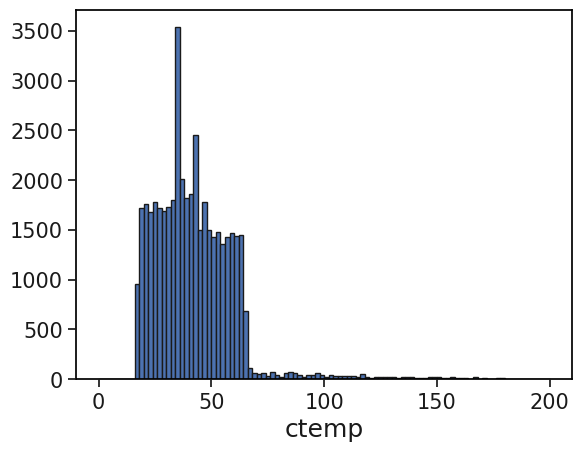

In [80]:
ds.ctemp.isnull().sum('pres')[ds.ctemp.isnull().sum('pres')>0].plot.hist(bins=np.arange(0,201,2))

(array([0.0000e+00, 3.7048e+04, 6.0410e+03, 1.7100e+02, 4.1900e+02,
        2.3000e+01, 2.7000e+01, 1.0000e+00, 0.0000e+00]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

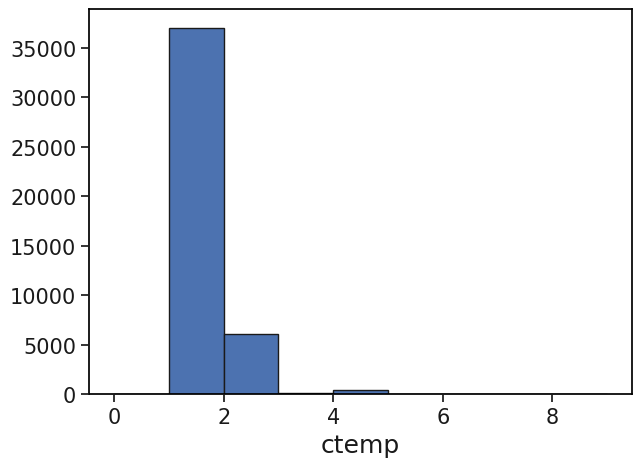

In [97]:
(ds.ctemp.isnull()[ds.ctemp.isnull().sum('pres')>0].astype(int).diff('pres').__abs__()>0).sum('pres'
        ).plot.hist(figsize=(7,5),bins=np.arange(0,10,1))

In [99]:
n_pr = (ds.ctemp.isnull()[ds.ctemp.isnull().sum('pres')>0].astype(int).diff('pres').__abs__()>0).sum('pres').n_prof

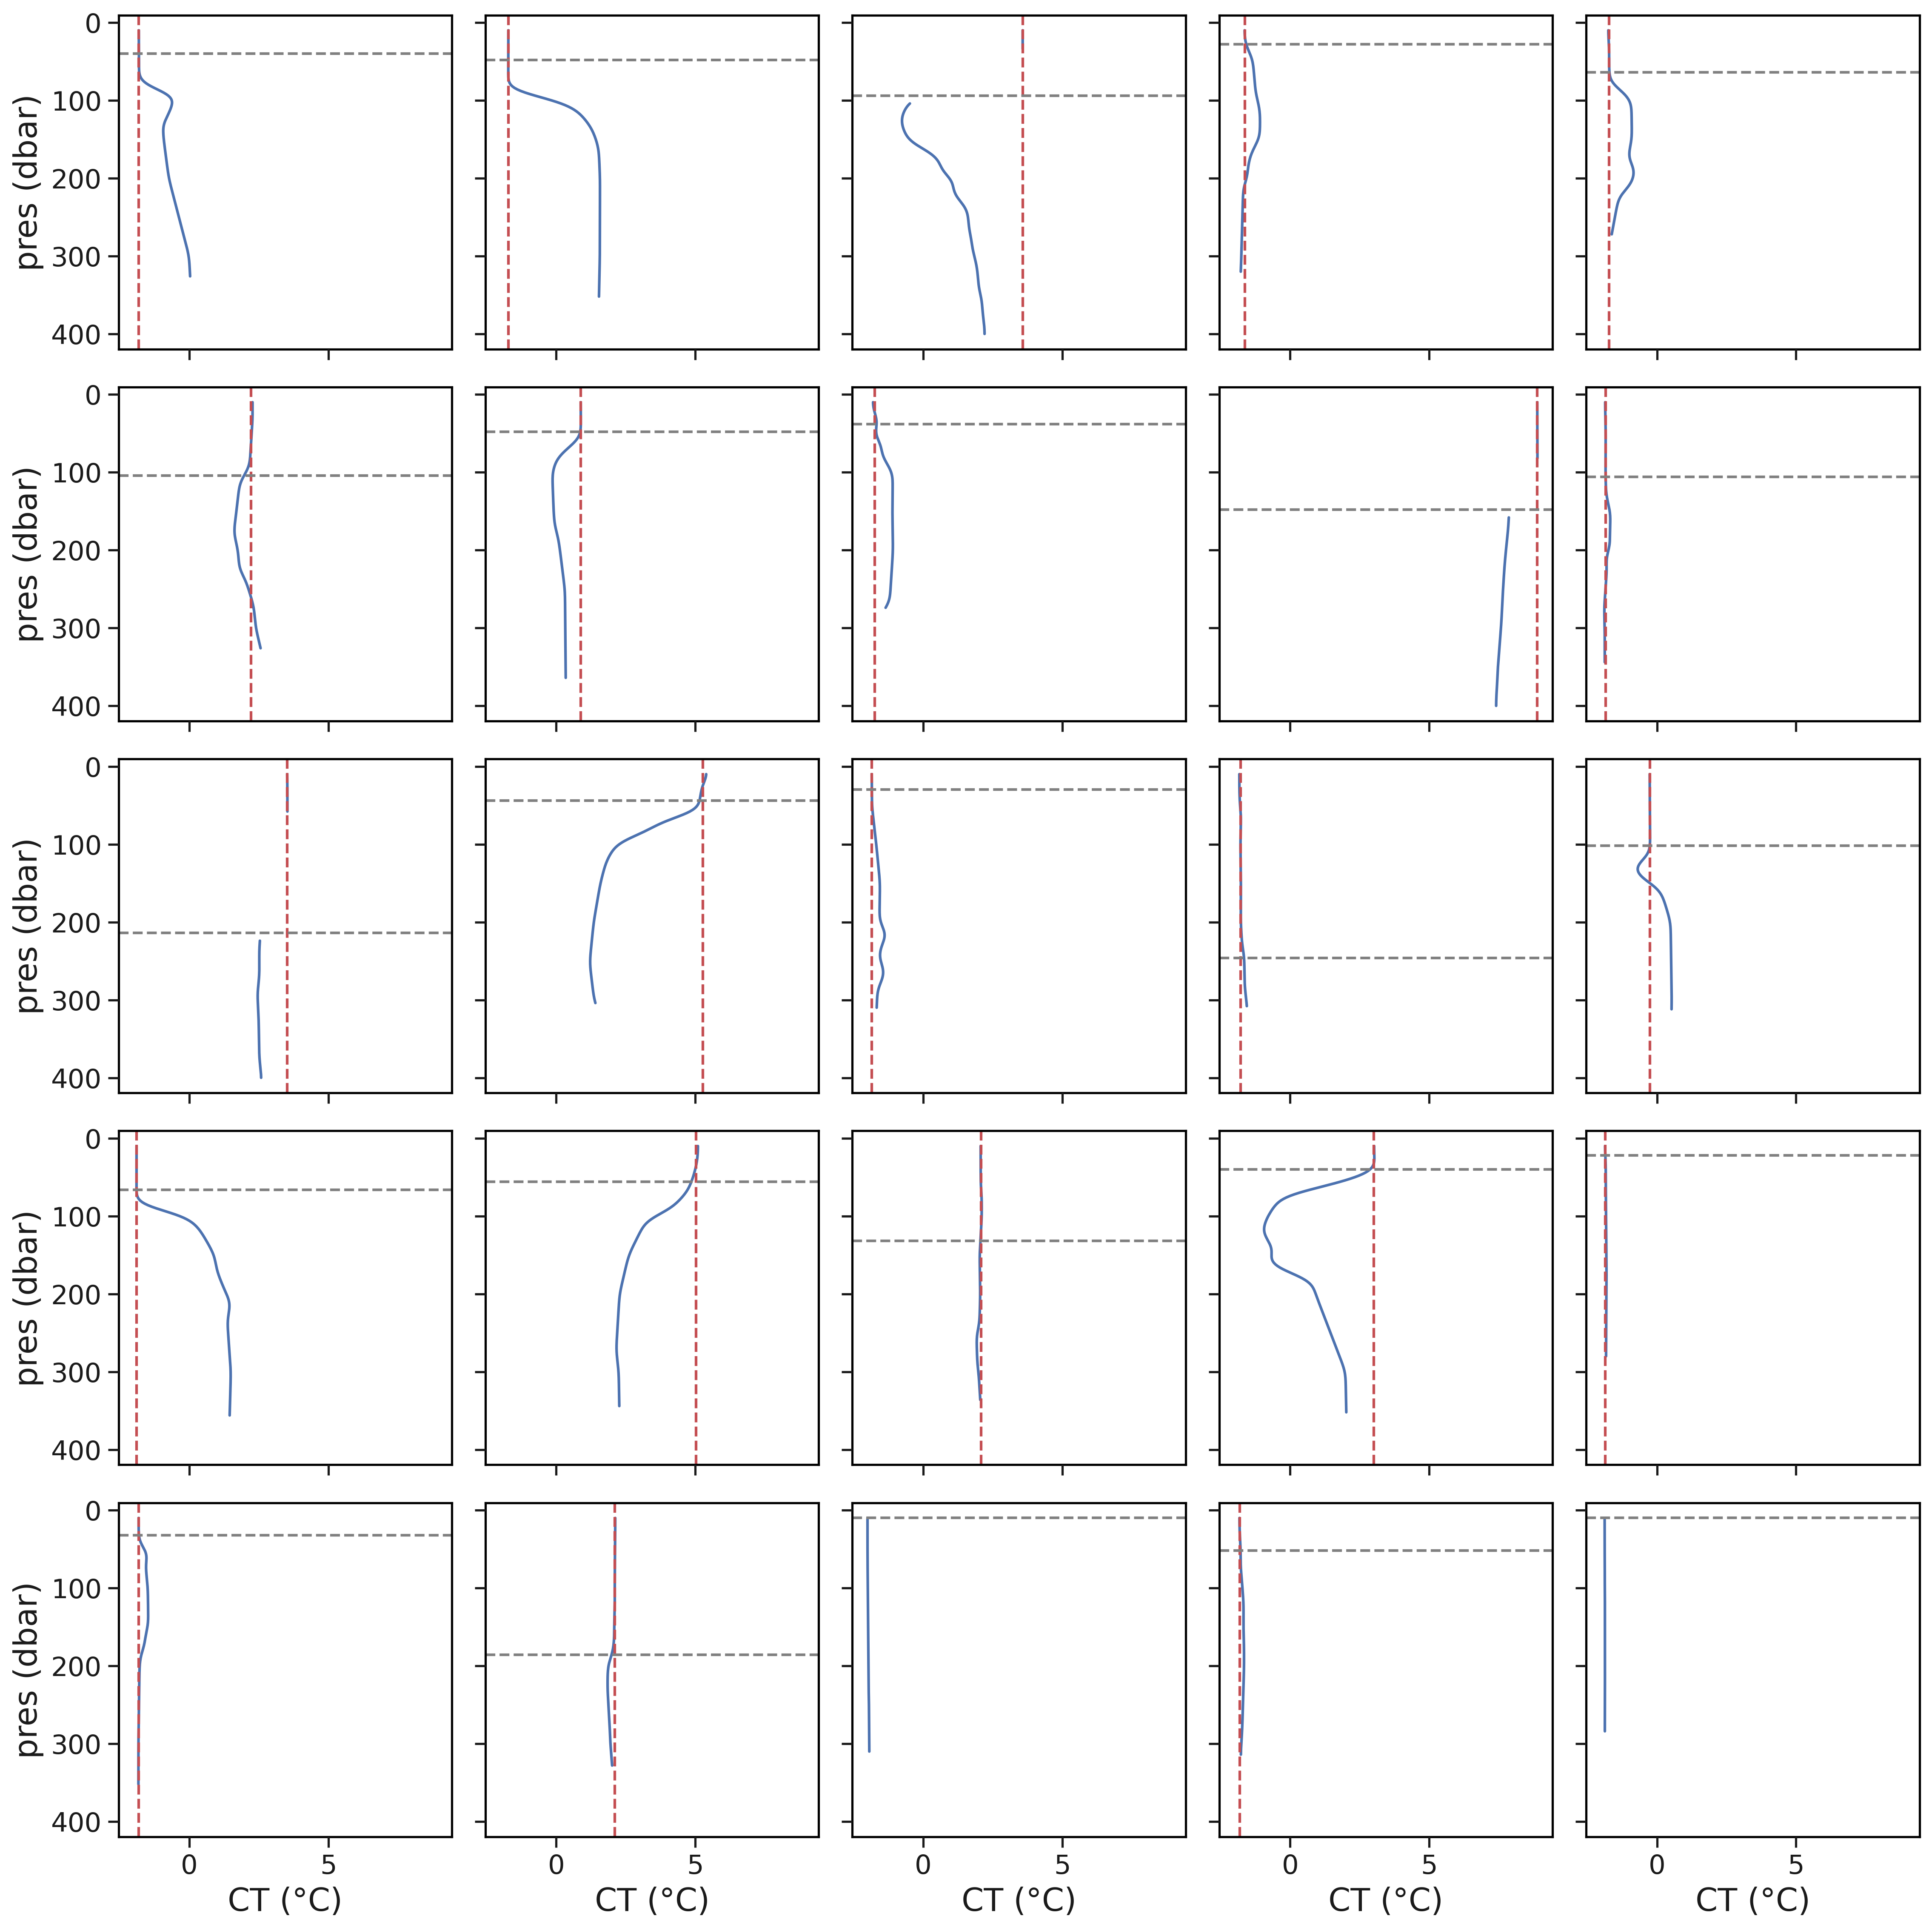

In [100]:
# randomly selected deep mixing profiles

r = 5
fig, ax = plt.subplots(r, r, figsize=(15, 15), sharey=True, sharex=True, dpi=300)
ax = ax.flatten()

# randomly select some profiles
x = np.asarray(np.random.choice(n_pr, r**2, replace=0))

# Loop over each subplot
for i, l, a in zip(range(len(ax)), x, ax):
    # Plot the original data
    ds.sel(n_prof=l).ctemp.plot(y='pres', ax=a)

    a.invert_yaxis()
    a.set_title('')
    a.set_xlabel('')
    a.set_ylabel('')

    a.axvline(ml_t.sel(n_prof=l),ls='--',c='r')
    a.axhline(ds.mlp.sel(n_prof=l),ls='--',c='grey')

# Set global limits for the plots
#plt.xlim(-2, 3)
plt.tight_layout()
#plt.show()

for a in ax[-r:]:
    a.set_xlabel('CT (°C)')

for a in ax[::5]:
    a.set_ylabel('pres (dbar)')

In [81]:
ds.ctemp.isnull().sum('pres')[ds.ctemp.isnull().sum('pres')>0]

<xarray.DataArray 'ctemp' (n_prof: 43730)>
array([37, 22, 24, ..., 34, 34, 69])
Coordinates:
  * n_prof   (n_prof) int64 38 224 249 276 298 ... 619979 620007 620063 620077
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 ...
    time     (n_prof) datetime64[ns] ...

In [85]:
np.unique(ds.dsource[ds.ctemp.isnull().sum('pres')>0],return_counts=1)

(array([array('Argo', dtype=object), array('CTD', dtype=object),
        array('Gliders', dtype=object), array('MEOP', dtype=object)],
       dtype=object),
 array([ 9444,    79,   377, 33830]))